In [1]:
import os
import pandas as pd
import numpy as np
import json

import xgboost as xgb
import matplotlib
import matplotlib.pyplot  as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
import math
import time
from scipy import stats
from statannotations.Annotator import Annotator
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer


%matplotlib inline

In [2]:
print(os.getpid())

214279


## Data import

In [3]:
lycopene_data = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/IPP_only_normalized_yb.csv', index_col = 0)
label = lycopene_data['result']
lycopene_data.drop(columns = ['result'], inplace = True)
col_list = lycopene_data.columns.tolist()

In [4]:
def preprocess(df, label, col_list):
    df_processed = []
    label_processed = []
    for group in df.groupby(df.columns.tolist()):
        idx_list = group[-1].index.tolist() # group의 인덱스 정보
        iter_num = len(idx_list)//3 # 3개의 row를 하나로
        for i in range(iter_num+1):
            try :
                tmp = idx_list[i*3:(i+1)*3]
            except :
                tmp = idx_list[i*3:]
            if len(tmp) > 0:
                df_processed.append(group[-1].iloc[0,:])
                label_processed.append(np.mean(label[tmp]))
    df_processed = pd.DataFrame(np.stack(df_processed), columns = col_list)
    label_processed = pd.Series(label_processed)
    return df_processed, label_processed

In [5]:
lycopene_processed, label_processed = preprocess(lycopene_data, label, col_list)

In [6]:
onehot_col_list = ['SlIdi', 'AtIdi', 'RcIdi', 'OgIdi',
                   'EcispA', 'KaispA', 'JcispA', 'SeispA', 'BaispA',
                   'PacrtE', 'KpcrtE', 'HpcrtE', 'NicrtE', 'ShcrtE',
                   'PacrtB', 'KpcrtB', 'LacrtB', 'RccrtB', 'SicrtB',
                   'PacrtI', 'ErcrtI', 'SscrtI', 'BvcrtI', 'LacrtI']
def make_onehot(df):
    enz_c = df[['Idi','ispA','CrtE','CrtB','CrtI']]
    enz_amount = df[['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']]
    
    enz_onehot = []
    col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
    for _, row in enz_c.iterrows():
        tmp = []
        for idx, enz in enumerate(['Idi','ispA','CrtE','CrtB','CrtI']):
            if enz == 'Idi':
                onehot = [0]*4
                if int(row[enz]) < 1:
                    tmp.extend(onehot)
                else:
                    onehot[int(row[enz])-1] = 1
                    tmp.extend(onehot)
            else:
                onehot = [0]*5
                if int(row[enz]) == 0:
                    tmp.extend(onehot)
                else:
                    onehot[int(row[enz])-1] = 1
                    tmp.extend(onehot)
        enz_onehot.append(tmp)
    enz_onehot = pd.DataFrame(enz_onehot, columns = onehot_col_list )
    
    df_onehot = pd.concat([enz_onehot, enz_amount], axis = 1)
    return df_onehot

In [7]:
lycopene_processed_onehot = make_onehot(lycopene_processed)
lycopene_onehot = make_onehot(lycopene_data)

In [8]:
lycopene_onehot

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.10,0.25,0.25,0.25,0.25
1,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.25,0.25,0.25,0.25,0.25
2,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.50,0.25,0.25,0.25,0.25
3,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1.00,0.25,0.25,0.25,0.25
4,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.10,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.00,0.25,0.25,0.25,0.25
286,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0.25,0.00,0.25,0.25,0.25
287,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0.25,0.25,0.00,0.25,0.25
288,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.25,0.25,0.25,0.00,0.25


In [103]:
random_test = pd.read_csv('/work/home/ybchae/active_learning/recommendation/random_test_set_result.csv')
random_label = random_test['result'].apply(lambda x: max(0, x))
random_test.drop(columns = ['result'], inplace = True)
random_test_processed, random_label_processed = preprocess(random_test, random_label, col_list)
random_test_processed_onehot = make_onehot(random_test_processed)

In [104]:
random_test_onehot = make_onehot(random_test)
random_test_onehot

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0.10,1.00,1.00,1.00,1.00
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,1.00,0.50,0.50,0.50,1.00
2,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1.00,0.25,0.50,0.25,0.10
3,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0.10,1.00,1.00,1.00,1.00
4,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1.00,1.00,0.25,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.10,1.00,0.50,0.10,0.25
86,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0.50,0.50,0.25,0.50,1.00
87,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0.50,0.50,0.10,1.00,0.25
88,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0.25,0.25,1.00,0.50,0.50


In [9]:
random_test_processed_onehot

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0.10,0.50,0.50,0.25,0.25
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.10,0.10,0.50,0.25,0.50
2,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0.10,0.25,1.00,0.25,0.10
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.10,1.00,0.50,0.10,0.25
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0.25,0.10,0.25,0.50,0.10
5,0,1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0.25,0.25,0.50,0.25,0.25
6,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0.25,1.00,1.00,0.50,0.25
7,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0.25,0.25,1.00,0.50,0.50
8,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0.50,1.00,0.25,0.50,0.50
9,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0.50,1.00,0.25,0.25,1.00


In [10]:
X_train, X_test, y_train, y_test = train_test_split(lycopene_processed_onehot, label_processed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

(77, 29) (20, 29)


In [179]:
METIS_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1_result.csv')
METIS_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2_result.csv')
METIS_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day3_result.csv')
METIS_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day4_result.csv')
METIS_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day5_result.csv')

METIS_day1_label = METIS_day1['result'].apply(lambda x: max(0, x))
METIS_day1.drop(columns = ['result'], inplace = True)
METIS_day1_processed, METIS_day1_label_processed = preprocess(METIS_day1, METIS_day1_label, col_list)
METIS_day1_processed_onehot = make_onehot(METIS_day1_processed)

METIS_day2_label = METIS_day2['result'].apply(lambda x: max(0, x))
METIS_day2.drop(columns = ['result'], inplace = True)
METIS_day2_processed, METIS_day2_label_processed = preprocess(METIS_day2, METIS_day2_label, col_list)
METIS_day2_processed_onehot = make_onehot(METIS_day2_processed)

METIS_day3_label = METIS_day3['result'].apply(lambda x: max(0, x))
METIS_day3.drop(columns = ['result'], inplace = True)
METIS_day3_processed, METIS_day3_label_processed = preprocess(METIS_day3, METIS_day3_label, col_list)
METIS_day3_processed_onehot = make_onehot(METIS_day3_processed)

METIS_day4_label = METIS_day4['result'].apply(lambda x: max(0, x))
METIS_day4.drop(columns = ['result'], inplace = True)
METIS_day4_processed, METIS_day4_label_processed = preprocess(METIS_day4, METIS_day4_label, col_list)
METIS_day4_processed_onehot = make_onehot(METIS_day4_processed)

METIS_day5_label = METIS_day5['result'].apply(lambda x: max(0, x))
METIS_day5.drop(columns = ['result'], inplace = True)
METIS_day5_processed, METIS_day5_label_processed = preprocess(METIS_day5, METIS_day5_label, col_list)
METIS_day5_processed_onehot = make_onehot(METIS_day5_processed)

test_x_METIS = np.concatenate((METIS_day1_processed_onehot,METIS_day2_processed_onehot,METIS_day3_processed_onehot,METIS_day4_processed_onehot), axis = 0)
test_y_METIS = np.concatenate((METIS_day1_label_processed, METIS_day2_label_processed, METIS_day3_label_processed, METIS_day4_label_processed), axis = 0)

In [188]:
M = pd.concat([METIS_day1_processed_onehot, METIS_day2_processed_onehot, METIS_day3_processed_onehot, METIS_day4_processed_onehot, METIS_day5_processed_onehot]).reset_index(drop = True)
M_label = pd.concat([METIS_day1_label_processed, METIS_day2_label_processed, METIS_day3_label_processed,  METIS_day4_label_processed, METIS_day5_label_processed]).reset_index(drop = True)

M.shape, M_label.shape

((50, 29), (50,))

In [181]:
HAL_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1_result.csv')
HAL_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2_result.csv')
HAL_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day3_result.csv')
HAL_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day4_result.csv')
HAL_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day5_result.csv')

HAL_day1_label = HAL_day1['result'].apply(lambda x: max(0, x))
HAL_day1.drop(columns = ['result'], inplace = True)
HAL_day1_processed, HAL_day1_label_processed = preprocess(HAL_day1, HAL_day1_label, col_list)
HAL_day1_processed_onehot = make_onehot(HAL_day1_processed)

HAL_day2_label = HAL_day2['result'].apply(lambda x: max(0, x))
HAL_day2.drop(columns = ['result'], inplace = True)
HAL_day2_processed, HAL_day2_label_processed = preprocess(HAL_day2, HAL_day2_label, col_list)
HAL_day2_processed_onehot = make_onehot(HAL_day2_processed)

HAL_day3_label = HAL_day3['result'].apply(lambda x: max(0, x))
HAL_day3.drop(columns = ['result'], inplace = True)
HAL_day3_processed, HAL_day3_label_processed = preprocess(HAL_day3, HAL_day3_label, col_list)
HAL_day3_processed_onehot = make_onehot(HAL_day3_processed)

HAL_day4_label = HAL_day4['result'].apply(lambda x: max(0, x))
HAL_day4.drop(columns = ['result'], inplace = True)
HAL_day4_processed, HAL_day4_label_processed = preprocess(HAL_day4, HAL_day4_label, col_list)
HAL_day4_processed_onehot = make_onehot(HAL_day4_processed)

HAL_day5_label = HAL_day5['result'].apply(lambda x: max(0, x))
HAL_day5.drop(columns = ['result'], inplace = True)
HAL_day5_processed, HAL_day5_label_processed = preprocess(HAL_day5, HAL_day5_label, col_list)
HAL_day5_processed_onehot = make_onehot(HAL_day5_processed)

test_x_HAL = np.concatenate((HAL_day1_processed_onehot, HAL_day2_processed_onehot, HAL_day3_processed_onehot, HAL_day4_processed_onehot), axis = 0)
test_y_HAL = np.concatenate((HAL_day1_label_processed, HAL_day2_label_processed, HAL_day3_label_processed, HAL_day4_label_processed), axis = 0)

In [189]:
H = pd.concat([HAL_day1_processed_onehot, HAL_day2_processed_onehot, HAL_day3_processed_onehot, HAL_day4_processed_onehot, HAL_day5_processed_onehot]).reset_index(drop = True)
H_label = pd.concat([HAL_day1_label_processed, HAL_day2_label_processed, HAL_day3_label_processed,  HAL_day4_label_processed, HAL_day5_label_processed]).reset_index(drop = True)

H.shape, H_label.shape

((50, 29), (50,))

In [183]:
METIS_optim_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day1_result.csv')
METIS_optim_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day2_result.csv')
METIS_optim_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day3_result.csv')
METIS_optim_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day4_result.csv')

METIS_optim_day1_label = METIS_optim_day1['result'].apply(lambda x: max(0, x))
METIS_optim_day1.drop(columns = ['result'], inplace = True)
METIS_optim_day1_processed, METIS_optim_day1_label_processed = preprocess(METIS_optim_day1, METIS_optim_day1_label, col_list)
METIS_optim_day1_processed_onehot = make_onehot(METIS_optim_day1_processed)

METIS_optim_day2_label = METIS_optim_day2['result'].apply(lambda x: max(0, x))
METIS_optim_day2.drop(columns = ['result'], inplace = True)
METIS_optim_day2_processed, METIS_optim_day2_label_processed = preprocess(METIS_optim_day2, METIS_optim_day2_label, col_list)
METIS_optim_day2_processed_onehot = make_onehot(METIS_optim_day2_processed)

METIS_optim_day3_label = METIS_optim_day3['result'].apply(lambda x: max(0, x))
METIS_optim_day3.drop(columns = ['result'], inplace = True)
METIS_optim_day3_processed, METIS_optim_day3_label_processed = preprocess(METIS_optim_day3, METIS_optim_day3_label, col_list)
METIS_optim_day3_processed_onehot = make_onehot(METIS_optim_day3_processed)

METIS_optim_day4_label = METIS_optim_day4['result'].apply(lambda x: max(0, x))
METIS_optim_day4.drop(columns = ['result'], inplace = True)
METIS_optim_day4_processed, METIS_optim_day4_label_processed = preprocess(METIS_optim_day4, METIS_optim_day4_label, col_list)
METIS_optim_day4_processed_onehot = make_onehot(METIS_optim_day4_processed)

test_x_METIS_optim = np.concatenate((METIS_optim_day1_processed_onehot,METIS_optim_day2_processed_onehot,METIS_optim_day3_processed_onehot,METIS_optim_day4_processed_onehot), axis = 0)
test_y_METIS_optim = np.concatenate((METIS_optim_day1_label_processed, METIS_optim_day2_label_processed, METIS_optim_day3_label_processed, METIS_optim_day4_label_processed), axis = 0)

In [190]:
M2 = pd.concat([METIS_optim_day1_processed_onehot, METIS_optim_day2_processed_onehot, METIS_optim_day3_processed_onehot, METIS_optim_day4_processed_onehot]).reset_index(drop = True)
M2_label = pd.concat([METIS_optim_day1_label_processed, METIS_optim_day2_label_processed, METIS_optim_day3_label_processed,  METIS_optim_day4_label_processed]).reset_index(drop = True)

M2.shape, M2_label.shape

((40, 29), (40,))

In [195]:
additional_all = pd.concat([M,M2,H]).reset_index(drop = True)
#additional_all_onehot = make_onehot(additional_all)
additional_all_label = pd.concat([M_label, M2_label, H_label]).reset_index(drop = True)

all_data = pd.concat([lycopene_processed_onehot, random_test_processed_onehot, additional_all]).reset_index(drop = True)
all_data_label = pd.concat([label_processed, random_label_processed, additional_all_label]).reset_index(drop= True)

In [196]:
all_data['result'] = all_data_label
all_data.to_csv('/work/home/ybchae/active_learning/data/lycopene/lycopene_triplet.csv', index = False)

In [199]:
all_data

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc,result
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0.00,0.25,0.25,0.25,0.25,0.179790
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0.10,0.25,0.25,0.25,0.25,0.639108
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0.25,0.00,0.25,0.25,0.25,0.782503
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0.25,0.10,0.25,0.25,0.25,0.912515
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.25,0.25,0.00,0.25,0.25,0.407725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1.00,0.10,1.00,0.10,1.00,0.350365
263,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0.25,1.00,0.10,0.25,0.10,0.374696
264,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0.25,0.10,1.00,0.10,0.50,0.355231
265,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0.25,0.00,0.50,1.00,0.25,0.834550


In [9]:
# X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_x.csv', index = False)
# X_test.to_csv('/work/home/ybchae/active_learning/data/lycopene/test_x.csv', index = False)
# y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_y.csv', index = False)
# y_test.to_csv('/work/home/ybchae/active_learning/data/lycopene/test_y.csv', index = False)

In [358]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
ispa_conc_list = [0,0.1,0.25,0.5,1] #ispa 가능한 농도
conc_list = [0.1,0.25,0.5, 1] # 가능한 농도

idi_enz_type = product([1,2,3,4], repeat = 1) #idi가능한 종류
enz_type = product([1,2,3,4,5], repeat = 4)

ispa_enz_conc = product(ispa_conc_list, repeat = 1)
enz_conc = product(conc_list, repeat = 4)

num = 0
ALL_possible_conditions = []
for i in tqdm(product(idi_enz_type,ispa_enz_conc,enz_type, enz_conc)):
    one_hot_encoded = np.zeros((1, 24))
    
    enz_type_tmp1 = np.array(i[0])
    enz_conc_tmp1 = np.array(i[1])
    enz_type_tmp2 = np.array(i[2])
    enz_conc_tmp2 = np.array(i[3])
    
    if enz_conc_tmp1[0] == 0: # ispA가 0
        enz_type_tmp2[0] = 0
    one_hot_encoded[0, enz_type_tmp1[0] -1] = 1 # IDI 인코딩
    for j, value in enumerate(enz_type_tmp2):
        if value > 0:
            one_hot_encoded[0, 4 + 5*j + value -1] = 1
    
    concat_tmp = np.concatenate((one_hot_encoded, enz_conc_tmp2[:1].reshape(1,-1), enz_conc_tmp1.reshape(1,-1), enz_conc_tmp2[1:].reshape(1,-1)), axis = 1)

    ALL_possible_conditions.append(concat_tmp)
    num += 1

ALL_possible_conditions = pd.DataFrame(np.squeeze(np.array(ALL_possible_conditions)), columns = col_list)
ALL_possible_conditions.drop_duplicates(inplace = True)
ALL_possible_conditions = ALL_possible_conditions.reset_index(drop = True)
print('Number of all possible experimental conditions : {}'.format(ALL_possible_conditions.shape[0]))

scaler = MinMaxScaler()
#scaler = StandardScaler()
scaled_ALL_possible_conditions = scaler.fit_transform(ALL_possible_conditions)
scaled_X_train = scaler.transform(lycopene_processed_onehot)
scaled_X_test = scaler.transform(random_test_processed_onehot)

#scaled_X_test_METIS = scaler.transform(test_x_METIS)
#scaled_X_test_HAL = scaler.transform(test_x_HAL)

3200000it [00:53, 59355.99it/s] 


Number of all possible experimental conditions : 2688000


In [9]:
def transform_df(df):
    df_conc = df.iloc[:,-5:]
    df_type = []
    for idx, row in df.iterrows():
        row_type = row[:-5]
        type_tmp = row_type[row_type!=0].index.tolist()
        if len(type_tmp) != 5: #ispA가 0일경우
            type_tmp = type_tmp[:1] + ['none'] + type_tmp[1:]
        type_tmp_num = []
        for t in type_tmp:
            type_tmp_num.append(homolog_num_dict[t])
        df_type.append(type_tmp_num)
    df_type = pd.DataFrame(df_type, columns =['Idi', 'ispA', 'CrtE','CrtB','CrtI'])
    df_transformed = pd.concat([df_type, df_conc], axis = 1)
    return df_transformed

## RandomSearch

In [10]:
ensemble_len = 20
# Create the grid search parameter and scoring functions
param_grid = {
    "learning_rate": [0.01, 0.03, 0.1, 0.3],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "max_depth": [2, 3, 4, 6 ,8],
    "objective": ['reg:absoluteerror'],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.4, 0.6],
    "min_child_weight": [1, 2, 4],
    "random_state" : [42],
    "nthread" : [2]}

# create the grid search object

def optimize_param(x,y):
    model = XGBRegressor(n_estimators = 500)
    
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter= 1000,
        random_state = 42)
    grid.fit(x, y)
    grid_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print(-1*np.mean(grid_results['mean_test_score'][:ensemble_len]))
    params_list = grid_results.params.iloc[0:ensemble_len,].tolist()
    return params_list, grid_results['mean_test_score'][:]

In [362]:
params_list, grid_results = optimize_param(scaled_X_train, label_processed)

0.34016989307686224


In [ ]:
day0_cv_total = []
for p in params_list:
    xgb_reg = XGBRegressor(**p, n_estimators = 500)
    cv_scores = cross_val_score(xgb_reg, scaled_X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    day0_cv_total.append(np.mean(cv_scores))
print(np.mean(day0_cv_total))

In [48]:
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day0_param.json', 'w') as f:
#     json.dump(params_list, f)

In [364]:
def test_func(p_list, x_train, x_test, y_train, y_test):
    test_mae = []
    test_pred_total = []
    d_train_onehot = xgb.DMatrix(x_train, y_train)
    d_test_onehot = xgb.DMatrix(x_test, y_test)
    for params in p_list :
        params['device'] = 'cuda:1'
        model = xgb.train(params, d_train_onehot, num_boost_round=500)
    
        test_pred = model.predict(d_test_onehot)
        test_pred_total.append(test_pred)
        mae = mean_absolute_error(y_test, test_pred)
        test_mae.append(mae)
    print('Test score : {}'.format(np.mean(test_mae)))
    return test_mae, test_pred_total

In [365]:
day0_mae, day0_pred  = test_func(params_list, scaled_X_train, scaled_X_test, label_processed, random_label_processed)
day0_r2 = []
for i in range(len(day0_pred)):
    day0_r2.append(r2_score(random_label_processed, day0_pred[i]))
print(np.mean(day0_r2))

Test score : 0.4758172092581335
0.08675846648848448


In [366]:
std_test = np.mean(np.std(day0_pred, axis = 0))

std_test

0.18234068

## Recommendation

In [12]:
exploration_param = {1: 1.41, 2: 1.41, 3: 1.41, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.5, 
                     9: 0.5, 10: 0.5 , 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.5, 
                     17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5}
homolog_num_dict = {"none" : 0, "SlIdi":1, 'AtIdi':2, 'RcIdi':3, 'OgIdi':4,
                   'EcispA':1, 'KaispA':2, 'JcispA':3, 'SeispA':4, 'BaispA':5,
                   'PacrtE':1, 'KpcrtE':2, 'HpcrtE':3, 'NicrtE':4, 'ShcrtE':5,
                   'PacrtB':1, 'KpcrtB':2, 'LacrtB':3, 'RccrtB':4, 'SicrtB':5,
                   'PacrtI':1, 'ErcrtI':2, 'SscrtI':3, 'BvcrtI':4, 'LacrtI':5}
def METIS_recommendation(p_list, X_selected, y_selected, X_not_selected, day, mode = 'prediction'):
    pred = []
    test_mae = []
    test_mse = []
    test_r2 = []

    d_selected = xgb.DMatrix(X_selected, y_selected)
    d_not_selected = xgb.DMatrix(X_not_selected, np.zeros(X_not_selected.shape[0]))
    for param in p_list:
        param['device'] = 'cuda:0'
        param['nthread'] = 2

        model = xgb.train(param, d_selected, num_boost_round=500)
        temp = model.predict(d_not_selected)
        pred.append(temp)
    if mode == 'prediction':
        exploration = 1
        exploitation = 0
    elif mode == 'optimization':
        exploration = exploration_param[day]
        exploitation = 1
    print(exploration,exploitation) 
        
    ucb_score = exploration * np.stack(pred).std(axis = 0) + exploitation * np.stack(pred).mean(axis = 0)
    ucb_df = pd.DataFrame(ucb_score, columns = ['UCB'])

    next_round_idx = ucb_df.sort_values(by = 'UCB', ascending = False).index.tolist()[:sampling_num]
    idx_list = []
    for idx in ucb_df.sort_values(by = 'UCB', ascending = False).index.tolist():
        target_row = X_not_selected[idx]
        row_exists = np.any(np.all(X_selected == target_row, axis=1))
        if row_exists : 
            continue
        else:
            idx_list.append(idx)
        if len(idx_list) == sampling_num:
            break
    print(next_round_idx, idx_list)

    return X_not_selected[next_round_idx]

def GS_recommendation(p_list, X_selected, y_selected, X_not_selected) :
    pred = []
    test_mae = []
    test_mse = []
    test_r2 = []

    d_selected = xgb.DMatrix(X_selected, y_selected)
    d_not_selected = xgb.DMatrix(X_not_selected, np.zeros(X_not_selected.shape[0]))
    
    for param in p_list:
        param['device'] = 'cuda:0'
        param['nthread'] = 2
        
        model = xgb.train(param, d_selected, num_boost_round=500)
        temp = model.predict(d_not_selected)
        pred.append(temp)

    for k in range(sampling_num):
        d_n = []
        for i in tqdm(range(X_not_selected.shape[0])):
            d_nm = [math.dist(sample,X_not_selected[i]) for sample in X_selected]
            d_n.append(np.min(d_nm))
    
        d_n_df = pd.DataFrame(d_n, columns = ['Dist'])
        idx = d_n_df.sort_values(by = 'Dist',ascending = False).index.tolist()[0]
        
        print(X_not_selected[idx].reshape(1,-1))
        X_selected = np.concatenate((X_selected, X_not_selected[idx].reshape(1,-1)), axis = 0)
        X_not_selected = np.delete(X_not_selected, idx, axis = 0)
        
    return X_selected[-sampling_num:]

def HAL_recommendation(p_list, X_selected, y_selected, X_not_selected, day):
    pred = []
    test_mae = []
    test_mse = []
    test_r2 = []
    
    d_selected = xgb.DMatrix(X_selected, y_selected)
    d_not_selected = xgb.DMatrix(X_not_selected, np.zeros(X_not_selected.shape[0]))
    
    for param in p_list:
        param['device'] = 'cuda:0'
        param['nthread'] = 2

        model = xgb.train(param, d_selected, num_boost_round=500)
        temp = model.predict(d_not_selected)
        pred.append(temp)
        
    M_param = ((day)/round_num)/2
    M_I_param = 1 - M_param
    print(round(M_I_param,3), round(M_param, 3))
    
    u_score = np.stack(pred).std(axis = 0)
    normalized_u_score = u_score/max(u_score)
    
    for k in range(sampling_num):
        d_n = []
        for i in tqdm(range(X_not_selected.shape[0])):
            d_nm = [math.dist(sample,X_not_selected[i]) for sample in X_selected]
            d_n.append(np.min(d_nm))
        normalized_d_n = d_n/np.max(d_n)
        d_n_df = pd.DataFrame(M_param*normalized_u_score + M_I_param*normalized_d_n, columns = ['HAL_score'])
        idx = d_n_df.sort_values(by = 'HAL_score',ascending = False).index.tolist()[0]
        print(X_not_selected[idx].reshape(1,-1))
        X_selected = np.concatenate((X_selected,X_not_selected[idx].reshape(1,-1)), axis = 0)
        X_not_selected = np.delete(X_not_selected, idx, axis = 0)
        normalized_u_score = np.delete(normalized_u_score, idx, axis = 0)

    return X_selected[-sampling_num:]

#### Day 1 recommend

In [126]:
sampling_num = 10
round_num = 5
day = 1
METIS_next = METIS_recommendation(params_list,scaled_X_train, y_train, scaled_ALL_possible_conditions, day)
METIS_optim_next = METIS_recommendation(params_list,scaled_X_train, y_train, scaled_ALL_possible_conditions, day, 'optimization')
#GS_next = GS_recommendation(params_list,scaled_X_train, y_train, sampled_possible_conditions)
HAL_next = HAL_recommendation(params_list,scaled_X_train, y_train, scaled_ALL_possible_conditions, day)

1 0
1.41 1
0.9 0.1


100%|██████████| 2856000/2856000 [14:41<00:00, 3241.24it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 1. 1. 1. 1.]]


100%|██████████| 2855999/2855999 [14:49<00:00, 3211.75it/s]


[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 1. 1.]]


100%|██████████| 2855998/2855998 [15:01<00:00, 3166.95it/s]


[[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  1. 1. 1. 1. 1.]]


100%|██████████| 2855997/2855997 [18:38<00:00, 2553.95it/s]


[[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 1. 0. 1.]]


100%|██████████| 2855996/2855996 [16:42<00:00, 2848.24it/s]


[[0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  1.  0.1 0.  1.  0. ]]


100%|██████████| 2855995/2855995 [15:48<00:00, 3009.60it/s]


[[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.1 1.  0.  1.  0. ]]


100%|██████████| 2855994/2855994 [15:49<00:00, 3006.40it/s]


[[0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.1 1.  1.  0.  1. ]]


100%|██████████| 2855993/2855993 [15:59<00:00, 2976.25it/s]


[[0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.1 1.  1.  0.  0. ]]


100%|██████████| 2855992/2855992 [16:07<00:00, 2952.18it/s]


[[0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.1 1.  0.  0.  1. ]]


100%|██████████| 2855991/2855991 [16:22<00:00, 2907.74it/s]


[[0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.25 0.1  0.   1.
  0.  ]]


In [659]:
np.mean(y_train)

0.9174869288398269

In [127]:
METIS_next_df = pd.DataFrame(scaler.inverse_transform(METIS_next), columns = col_list)
METIS_optim_next_df = pd.DataFrame(scaler.inverse_transform(METIS_optim_next), columns = col_list)
#GS_next_df = pd.DataFrame(scaler.inverse_transform(GS_next), columns = col_list)
HAL_next_df = pd.DataFrame(scaler.inverse_transform(HAL_next), columns = col_list)

In [162]:
METIS_next_conc = METIS_next_df.iloc[:,-5:]
METIS_next_type = []
for idx, row in METIS_next_df.iterrows():
    row_type = row[:-5]
    type_tmp = row_type[row_type!=0].index.tolist()
    type_tmp = ['none']*(5-len(type_tmp)) + type_tmp
    type_tmp_num = []
    for t in type_tmp:
        type_tmp_num.append(homolog_num_dict[t])
    METIS_next_type.append(type_tmp_num)
METIS_next_type = pd.DataFrame(METIS_next_type, columns =['Idi', 'ispA', 'CrtE','CrtB','CrtI'])
METIS_next_df_transformed = pd.concat([METIS_next_type, METIS_next_conc], axis = 1)

In [191]:
METIS_next_df_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,3,3,4,4,0.25,0.1,0.1,1.0,0.25
1,4,3,3,2,4,0.25,0.1,0.1,1.0,0.25
2,4,5,3,4,4,0.25,0.1,0.1,1.0,0.25
3,4,3,3,4,4,0.50,0.1,0.1,1.0,0.25
4,4,3,3,2,4,0.50,0.1,0.1,1.0,0.25
5,4,3,3,4,4,0.25,0.1,0.1,0.5,0.25
6,4,5,3,4,4,0.50,0.1,0.1,1.0,0.25
7,4,5,3,2,4,0.25,0.1,0.1,1.0,0.25
8,4,5,3,2,4,0.50,0.1,0.1,1.0,0.25
9,4,3,3,4,4,0.10,0.1,0.1,1.0,0.25


In [163]:
METIS_next_df_transformed.iloc[:, :5].value_counts() #ECispA, SiIDI, LpcrtE, LpcrtB, LacrtI

Idi  ispA  CrtE  CrtB  CrtI
4    3     3     4     4       4
                 2     4       2
     5     3     2     4       2
                 4     4       2
Name: count, dtype: int64

In [164]:
METIS_next_df_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1.csv', index = False)

In [165]:
METIS_optim_next_conc = METIS_optim_next_df.iloc[:,-5:]
METIS_optim_next_type = []
for idx, row in METIS_optim_next_df.iterrows():
    row_type = row[:-5]
    type_tmp = row_type[row_type!=0].index.tolist()
    type_tmp = ['none']*(5-len(type_tmp)) + type_tmp
    type_tmp_num = []
    for t in type_tmp:
        type_tmp_num.append(homolog_num_dict[t])
    METIS_optim_next_type.append(type_tmp_num)
METIS_optim_next_type = pd.DataFrame(METIS_optim_next_type,columns =['Idi', 'ispA', 'CrtE','CrtB','CrtI'])

METIS_optim_next_df_transformed = pd.concat([METIS_optim_next_type, METIS_optim_next_conc], axis = 1)

In [166]:
METIS_optim_next_df_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,3,3,4,4,0.25,0.25,0.1,0.25,0.25
1,4,3,3,2,4,0.25,0.25,0.1,0.25,0.25
2,4,3,3,1,4,0.25,0.25,0.1,0.25,0.25
3,4,3,3,4,4,0.50,0.25,0.1,0.25,0.25
4,4,3,3,2,4,0.50,0.25,0.1,0.25,0.25


In [167]:
METIS_optim_next_df_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day1.csv', index = False)

In [168]:
HAL_next_conc = HAL_next_df.iloc[:,-5:]
HAL_next_type = []
for idx, row in HAL_next_df.iterrows():
    row_type = row[:-5]
    type_tmp = row_type[row_type!=0].index.tolist()
    type_tmp = ['none']*(5-len(type_tmp)) + type_tmp
    type_tmp_num = []
    for t in type_tmp:
        type_tmp_num.append(homolog_num_dict[t])
    HAL_next_type.append(type_tmp_num)
HAL_next_type = pd.DataFrame(HAL_next_type,columns =['Idi', 'ispA', 'CrtE','CrtB','CrtI'])

HAL_next_df_transformed = pd.concat([HAL_next_type, HAL_next_conc], axis = 1)

In [169]:
HAL_next_df_transformed 

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,2,5,5,5,3,1.00,1.0,1.0,1.0,1.0
1,4,4,3,2,4,1.00,1.0,0.1,1.0,1.0
2,3,3,2,3,5,1.00,1.0,1.0,1.0,1.0
3,4,2,4,4,2,1.00,1.0,1.0,0.1,1.0
4,3,3,3,4,2,1.00,0.1,0.1,1.0,0.1
5,2,2,2,4,3,0.10,1.0,0.1,1.0,0.1
6,2,4,2,2,2,0.10,1.0,1.0,0.1,1.0
7,4,3,5,3,3,0.10,1.0,1.0,0.1,0.1
8,2,3,4,5,5,0.10,1.0,0.1,0.1,1.0
9,4,5,3,3,5,0.25,0.1,0.1,1.0,0.1


In [170]:
HAL_next_df_transformed.iloc[:, :5].value_counts() #ECispA, SiIDI, LpcrtE, LpcrtB, LacrtI

Idi  ispA  CrtE  CrtB  CrtI
2    2     2     4     3       1
     3     4     5     5       1
     4     2     2     2       1
     5     5     5     3       1
3    3     2     3     5       1
           3     4     2       1
4    2     4     4     2       1
     3     5     3     3       1
     4     3     2     4       1
     5     3     3     5       1
Name: count, dtype: int64

In [171]:
HAL_next_df_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1.csv', index = False)

#### Day2

In [282]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day0_param.json', 'r') as f:
    params_list = json.load(f)

In [283]:
METIS_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1_result.csv')
METIS_day1_optim = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day1_result.csv')
HAL_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1_result.csv')

METIS_day1_label = METIS_day1['result'].apply(lambda x: max(0, x))
METIS_day1.drop(columns = ['result'], inplace = True)

METIS_day1_optim_label = METIS_day1_optim['result'].apply(lambda x: max(0, x))
METIS_day1_optim.drop(columns = ['result'], inplace = True)

HAL_day1_label = HAL_day1['result'].apply(lambda x: max(0, x))
HAL_day1.drop(columns = ['result'], inplace = True)

col_list = METIS_day1.columns.tolist()

In [284]:
METIS_day1_processed, METIS_day1_label_processed = preprocess(METIS_day1, METIS_day1_label, col_list)
METIS_day1_optim_processed, METIS_day1_optim_label_processed = preprocess(METIS_day1_optim, METIS_day1_optim_label, col_list)
HAL_day1_processed, HAL_day1_label_processed = preprocess(HAL_day1, HAL_day1_label, col_list)

In [285]:
np.mean(METIS_day1_label_processed),np.mean(METIS_day1_optim_label_processed), np.mean(HAL_day1_label_processed)

(2.095294117566667, 2.1394117646, 0.9576470587566668)

In [286]:
METIS_day1_processed_onehot = make_onehot(METIS_day1_processed)
METIS_day1_optim_processed_onehot = make_onehot(METIS_day1_optim_processed)
HAL_day1_processed_onehot = make_onehot(HAL_day1_processed)

In [287]:
day0_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_x.csv')
#X_test = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/test_x.csv')
day0_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_y.csv')
#y_test = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/test_y.csv')

In [288]:
METIS_day1_X_train = pd.concat([day0_X_train, METIS_day1_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day1_y_train = pd.concat([day0_y_train['0'], METIS_day1_label_processed], axis = 0).reset_index(drop = True)

METIS_day1_optim_X_train = pd.concat([day0_X_train, METIS_day1_optim_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day1_optim_y_train = pd.concat([day0_y_train['0'], METIS_day1_optim_label_processed], axis = 0).reset_index(drop = True)

HAL_day1_X_train = pd.concat([day0_X_train, HAL_day1_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day1_y_train = pd.concat([day0_y_train['0'], HAL_day1_label_processed], axis = 0).reset_index(drop = True)

In [289]:
# METIS_day1_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_x.csv', index = False)
# METIS_day1_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_y.csv', index = False)

# METIS_day1_optim_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day1_train_x.csv', index = False)
# METIS_day1_optim_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day1_train_y.csv', index = False)

# HAL_day1_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_x.csv', index = False)
# HAL_day1_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_y.csv', index = False)

In [290]:
scaled_METIS_day1_X_train = scaler.transform(METIS_day1_X_train)
scaled_METIS_day1_optim_X_train = scaler.transform(METIS_day1_optim_X_train)
scaled_HAL_day1_X_train = scaler.transform(HAL_day1_X_train)

scaled_METIS_day1_X_train.shape,scaled_METIS_day1_optim_X_train.shape, scaled_HAL_day1_X_train.shape

((87, 29), (87, 29), (87, 29))

In [291]:
METIS_day1_params_list, METIS_day1_grid_results = optimize_param(scaled_METIS_day1_X_train, METIS_day1_y_train)
#METIS_day1_optim_params_list, METIS_day1_optim_grid_results = optimize_param(scaled_METIS_day1_optim_X_train, METIS_day1_optim_y_train)
HAL_day1_params_list, HAL_day1_grid_results = optimize_param(scaled_HAL_day1_X_train, HAL_day1_y_train)

0.2216266291409006
0.2191170933649734


In [79]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_METIS_param.json', 'w') as f:
    json.dump(METIS_day1_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_HAL_param.json', 'w') as f:
    json.dump(HAL_day1_params_list, f)

1.2776908816368986 0.20910918698851105


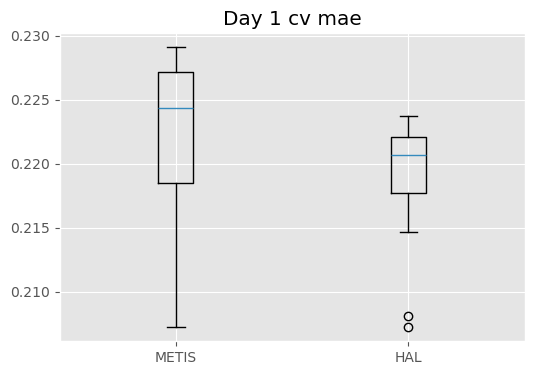

In [77]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day1_cv = [-1*METIS_day1_grid_results[:20], -1*HAL_day1_grid_results[:20]]
plt.boxplot(day1_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day1_grid_results[:20], -1*HAL_day1_grid_results[:20])
print(t, p_value)

In [80]:
METIS_day1_cv_total = []
HAL_day1_cv_total = []
for i in range(20):
    xgb_reg_METIS = XGBRegressor(**params_list[i], n_estimators = 500)
    xgb_reg_HAL = XGBRegressor(**params_list[i], n_estimators = 500)
    METIS_cv_scores = cross_val_score(xgb_reg_METIS, scaled_METIS_day1_X_train, METIS_day1_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    HAL_cv_scores = cross_val_score(xgb_reg_HAL, scaled_HAL_day1_X_train, HAL_day1_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    METIS_day1_cv_total.append(np.mean(METIS_cv_scores))
    HAL_day1_cv_total.append(np.mean(HAL_cv_scores))
np.mean(METIS_day1_cv_total), np.mean(HAL_day1_cv_total)

/work/home/ybchae/anaconda3/envs/yb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:22:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


(0.2693380162646794, 0.25688030794112093)

In [292]:
METIS_day1_mae, METIS_day1_pred = test_func(METIS_day1_params_list, scaled_METIS_day1_X_train, scaled_X_test, METIS_day1_y_train, random_label_processed)
HAL_day1_mae, HAL_day1_pred = test_func(HAL_day1_params_list, scaled_HAL_day1_X_train, scaled_X_test, HAL_day1_y_train, random_label_processed)

Test score : 0.46767055441625516
Test score : 0.379551436910123


In [295]:
M1_std_test = np.mean(np.std(METIS_day1_pred, axis = 0))
H1_std_test = np.mean(np.std(HAL_day1_pred, axis = 0))

M1_std_test, H1_std_test

(0.21283047, 0.1390459)

In [81]:
t, p_value = stats.ttest_ind(METIS_day1_mae,HAL_day1_mae)
print(t, p_value)

7.1660138105381535 1.4678617528233406e-08


Text(0.5, 1.0, 'Day 1 test mae')

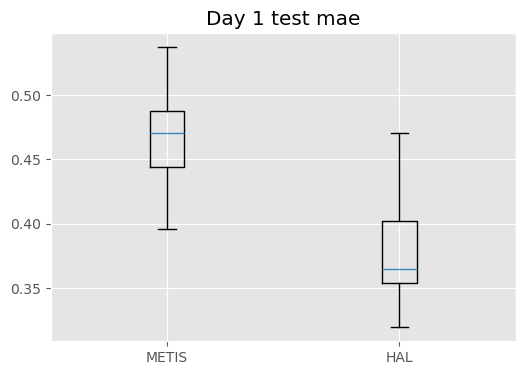

In [82]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')


x = np.arange(2)
day1_mae = [METIS_day1_mae, HAL_day1_mae]
plt.boxplot(day1_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 test mae")

In [83]:
METIS_day1_r2 = []
HAL_day1_r2 = []
for i in range(len(METIS_day1_pred)):
    METIS_day1_r2.append(r2_score(random_label_processed, METIS_day1_pred[i]))
    HAL_day1_r2.append(r2_score(random_label_processed, HAL_day1_pred[i]))
print(np.mean(METIS_day1_r2))
print(np.mean(HAL_day1_r2))

0.03871636256713936
0.45292122837304066


Text(0.5, 1.0, 'Day 1 R2')

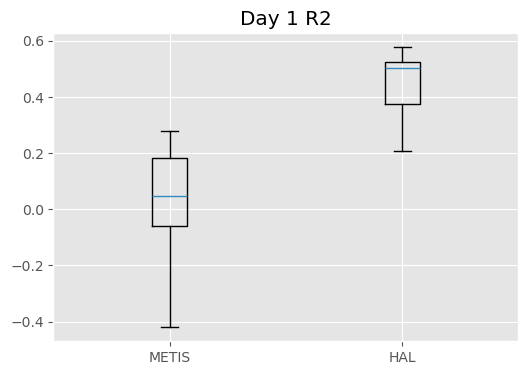

In [84]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day1_r2 = [METIS_day1_r2, HAL_day1_r2]
plt.boxplot(day1_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 R2")

In [85]:
t, p_value = stats.ttest_ind(METIS_day1_r2,HAL_day1_r2)
print(t, p_value)

-8.744237150218273 1.2385097823614988e-10


In [195]:
METIS_day1_mae2, METIS_day1_pred2 = test_func(METIS_day1_params_list, scaled_METIS_day1_X_train, scaled_X_test_small, METIS_day1_y_train, y_test_small)
HAL_day1_mae2, HAL_day1_pred2 = test_func(HAL_day1_params_list, scaled_HAL_day1_X_train, scaled_X_test_small, HAL_day1_y_train, y_test_small)

t, p_value = stats.ttest_ind(METIS_day1_mae2,HAL_day1_mae2)
print(t, p_value)

METIS_day1_r2_2 = []
HAL_day1_r2_2 = []
for i in range(len(METIS_day1_pred2)):
    METIS_day1_r2_2.append(r2_score(y_test_small, METIS_day1_pred2[i]))
    HAL_day1_r2_2.append(r2_score(y_test_small, HAL_day1_pred2[i]))
    
print(np.mean(METIS_day1_r2_2))
print(np.mean(HAL_day1_r2_2))

t, p_value = stats.ttest_ind(METIS_day1_r2_2,HAL_day1_r2_2)
print(t, p_value)

Test score : 0.14617813251819123
Test score : 0.13165591438895086
2.542254698718802 0.015211793477028874
0.6373100220518275
0.698801194093811
-2.1274124392572924 0.03993472621128883


#### Day2 recommend

In [72]:
sampling_num = 10
round_num = 5
day = 2
METIS_day2_recommend = METIS_recommendation(METIS_day1_params_list, scaled_METIS_day1_X_train, METIS_day1_y_train, scaled_ALL_possible_conditions, day)
METIS_optim_day2_recommend = METIS_recommendation(METIS_day1_optim_params_list, scaled_METIS_day1_optim_X_train, METIS_day1_optim_y_train, scaled_ALL_possible_conditions, day, 'optimization')
#GS_next = GS_recommendation(params_list,scaled_X_train, y_train, sampled_possible_conditions)
HAL_day2_recommend = HAL_recommendation(HAL_day1_params_list, scaled_HAL_day1_X_train, HAL_day1_y_train, scaled_ALL_possible_conditions, day)

1 0
1.41 1
0.8 0.2


100%|██████████| 2856000/2856000 [22:44<00:00, 2092.49it/s]


[[0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.1 1.  1.  0.  1. ]]


100%|██████████| 2855999/2855999 [22:47<00:00, 2089.07it/s]


[[0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.5  0.25 1.   1.
  0.  ]]


100%|██████████| 2855998/2855998 [22:39<00:00, 2100.24it/s]


[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  1. 1. 1. 0. 1.]]


100%|██████████| 2855997/2855997 [23:24<00:00, 2033.18it/s]


[[0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.1 1.  0.  0. ]]


100%|██████████| 2855996/2855996 [23:37<00:00, 2015.34it/s]


[[0.         1.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         1.
  1.         0.5        1.         0.44444444 0.        ]]


100%|██████████| 2855995/2855995 [23:52<00:00, 1993.85it/s]


[[0.         0.         1.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.25       0.1        0.16666667 1.         1.        ]]


100%|██████████| 2855994/2855994 [24:11<00:00, 1967.42it/s]


[[0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   1.   0.   1.   0.   0.   0.   0.1  0.25 1.   0.
  0.  ]]


100%|██████████| 2855993/2855993 [24:24<00:00, 1950.14it/s]


[[1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.1 1.  1.  1.  0. ]]


100%|██████████| 2855992/2855992 [24:49<00:00, 1917.96it/s]


[[0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.25 0.1  0.   0.
  1.  ]]


100%|██████████| 2855991/2855991 [24:58<00:00, 1906.18it/s]


[[0.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.1  0.25 0.   0.
  0.  ]]


In [83]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
METIS_day2_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_day2_recommend), columns = col_list)
METIS_day2_optim_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_optim_day2_recommend), columns = col_list)
HAL_day2_recommend_df = pd.DataFrame(scaler.inverse_transform(HAL_day2_recommend), columns = col_list)

In [84]:
METIS_day2_recommend_transformed = transform_df(METIS_day2_recommend_df)
METIS_day2_optim_recommend_transformed = transform_df(METIS_day2_optim_recommend_df)
HAL_day2_recommend_transformed = transform_df(HAL_day2_recommend_df)

In [103]:
METIS_day2_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,5,1,4,5,0.25,0.25,1.0,0.1,0.1
1,4,3,1,4,5,0.25,0.50,1.0,0.1,0.1
2,2,1,1,1,5,1.00,0.10,1.0,1.0,0.1
3,3,3,1,2,5,0.25,0.25,1.0,0.1,0.1
4,1,1,1,1,5,1.00,0.50,1.0,0.5,0.1
5,4,5,1,4,5,0.25,0.50,1.0,0.1,0.1
6,4,4,1,4,5,0.25,0.25,1.0,0.1,0.1
7,4,3,1,2,5,0.25,0.25,1.0,0.1,0.1
8,4,3,1,4,5,0.25,0.25,1.0,0.1,0.1
9,4,4,1,4,5,0.25,0.50,1.0,0.1,0.1


In [104]:
METIS_day2_recommend_transformed.iloc[:, :5].value_counts()

Idi  ispA  CrtE  CrtB  CrtI
4    5     1     4     5       2
     4     1     4     5       2
     3     1     4     5       2
3    3     1     2     5       1
2    1     1     1     5       1
1    1     1     1     5       1
4    3     1     2     5       1
Name: count, dtype: int64

In [85]:
HAL_day2_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,3,2,3,5,4,0.10,1.00,1.00,0.1,1.0
1,2,4,4,3,4,0.50,0.25,1.00,1.0,0.1
2,1,4,3,3,3,1.00,1.00,1.00,0.1,1.0
3,3,5,5,2,4,1.00,0.10,1.00,0.1,0.1
4,2,2,3,2,5,1.00,0.50,1.00,0.5,0.1
5,3,4,4,4,3,0.25,0.10,0.25,1.0,1.0
6,4,4,3,5,2,0.10,0.25,1.00,0.1,0.1
7,1,5,3,2,2,0.10,1.00,1.00,1.0,0.1
8,2,5,3,4,4,0.25,0.10,0.10,0.1,1.0
9,4,2,4,2,3,0.10,0.25,0.10,0.1,0.1


In [105]:
HAL_day2_recommend_transformed.iloc[:, :5].value_counts()

Idi  ispA  CrtE  CrtB  CrtI
1    4     3     3     3       1
     5     3     2     2       1
2    2     3     2     5       1
     4     4     3     4       1
     5     3     4     4       1
3    2     3     5     4       1
     4     4     4     3       1
     5     5     2     4       1
4    2     4     2     3       1
     4     3     5     2       1
Name: count, dtype: int64

In [101]:
METIS_day2_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2.csv', index = False)
METIS_day2_optim_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day2.csv', index = False)
HAL_day2_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2.csv', index = False)

#### Day3

In [40]:
# load data
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_METIS_param.json', 'r') as f:
#     day1_METIS_params_list = json.load(f)
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_HAL_param.json', 'r') as f:
#     day1_HAL_params_list = json.load(f)

In [296]:
METIS_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2_result.csv')
METIS_day2_optim = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day2_result.csv')
HAL_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2_result.csv')

METIS_day2_label = METIS_day2['result'].apply(lambda x: max(0, x))
METIS_day2.drop(columns = ['result'], inplace = True)

METIS_day2_optim_label = METIS_day2_optim['result'].apply(lambda x: max(0, x))
METIS_day2_optim.drop(columns = ['result'], inplace = True)

HAL_day2_label = HAL_day2['result'].apply(lambda x: max(0, x))
HAL_day2.drop(columns = ['result'], inplace = True)

col_list = METIS_day2.columns.tolist()

In [297]:
METIS_day2_processed, METIS_day2_label_processed = preprocess(METIS_day2, METIS_day2_label, col_list)
METIS_day2_optim_processed, METIS_day2_optim_label_processed = preprocess(METIS_day2_optim, METIS_day2_optim_label, col_list)
HAL_day2_processed, HAL_day2_label_processed = preprocess(HAL_day2, HAL_day2_label, col_list)

In [298]:
np.mean(METIS_day2_label_processed),np.mean(METIS_day2_optim_label_processed), np.mean(HAL_day2_label_processed)

(1.0850678733666668, 1.9752941176333334, 0.8850678733433334)

In [299]:
METIS_day2_processed_onehot = make_onehot(METIS_day2_processed)
METIS_day2_optim_processed_onehot = make_onehot(METIS_day2_optim_processed)
HAL_day2_processed_onehot = make_onehot(HAL_day2_processed)

In [300]:
METIS_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_x.csv')
METIS_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_y.csv')

METIS_optim_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day1_train_x.csv')
METIS_optim_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day1_train_y.csv')

HAL_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_x.csv')
HAL_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_y.csv')

In [301]:
METIS_day2_X_train = pd.concat([METIS_day1_X_train, METIS_day2_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day2_y_train = pd.concat([METIS_day1_y_train['0'], METIS_day2_label_processed], axis = 0).reset_index(drop = True)

METIS_day2_optim_X_train = pd.concat([METIS_optim_day1_X_train, METIS_day2_optim_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day2_optim_y_train = pd.concat([METIS_optim_day1_y_train['0'], METIS_day2_optim_label_processed], axis = 0).reset_index(drop = True)

HAL_day2_X_train = pd.concat([HAL_day1_X_train, HAL_day2_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day2_y_train = pd.concat([HAL_day1_y_train['0'], HAL_day2_label_processed], axis = 0).reset_index(drop = True)

In [50]:
# METIS_day2_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_x.csv', index = False)
# METIS_day2_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_y.csv', index = False)

# METIS_day2_optim_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day2_train_x.csv', index = False)
# METIS_day2_optim_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day2_train_y.csv', index = False)

# HAL_day2_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_x.csv', index = False)
# HAL_day2_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_y.csv', index = False)

In [302]:
scaled_METIS_day2_X_train = scaler.transform(METIS_day2_X_train)
scaled_METIS_day2_optim_X_train = scaler.transform(METIS_day2_optim_X_train)
scaled_HAL_day2_X_train = scaler.transform(HAL_day2_X_train)

scaled_METIS_day2_X_train.shape,scaled_METIS_day2_optim_X_train.shape, scaled_HAL_day2_X_train.shape

((97, 29), (97, 29), (97, 29))

In [303]:
METIS_day2_params_list, METIS_day2_grid_results = optimize_param(scaled_METIS_day2_X_train, METIS_day2_y_train)
#METIS_day2_optim_params_list, METIS_day2_optim_grid_results = optimize_param(scaled_METIS_day2_optim_X_train, METIS_day2_optim_y_train)
HAL_day2_params_list, HAL_day2_grid_results = optimize_param(scaled_HAL_day2_X_train, HAL_day2_y_train)

0.24909155411787273
0.2857664194231483


-20.228531307069346 6.080601153973774e-22


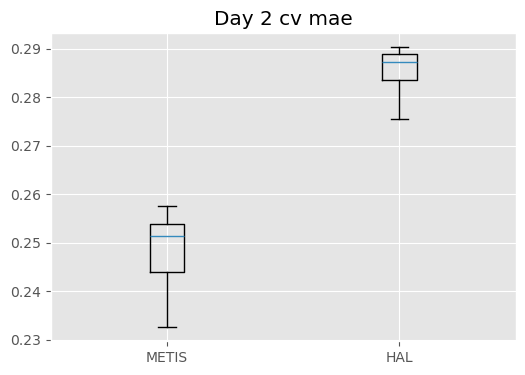

In [94]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_cv = [-1*METIS_day2_grid_results[:20], -1*HAL_day2_grid_results[:20]]
plt.boxplot(day2_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day2_grid_results[:20], -1*HAL_day2_grid_results[:20])
print(t, p_value)

In [95]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_METIS_param.json', 'w') as f:
    json.dump(METIS_day2_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_HAL_param.json', 'w') as f:
    json.dump(HAL_day2_params_list, f)

In [304]:
METIS_day2_mae, METIS_day2_pred = test_func(METIS_day2_params_list, scaled_METIS_day2_X_train, scaled_X_test, METIS_day2_y_train, random_label_processed)
HAL_day2_mae, HAL_day2_pred = test_func(HAL_day2_params_list, scaled_HAL_day2_X_train, scaled_X_test, HAL_day2_y_train, random_label_processed)

Test score : 0.47247483078617625
Test score : 0.2917309701462952


In [305]:
M2_std_test = np.mean(np.std(METIS_day2_pred, axis = 0))
H2_std_test = np.mean(np.std(HAL_day2_pred, axis = 0))

M2_std_test, H2_std_test

(0.24060135, 0.14544956)

11.633581756979062 4.33240140356528e-14


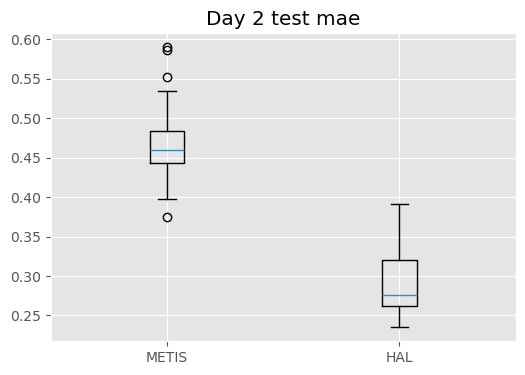

In [97]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_mae = [METIS_day2_mae, HAL_day2_mae]
plt.boxplot(day2_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 test mae")

t, p_value = stats.ttest_ind(METIS_day2_mae,HAL_day2_mae)
print(t, p_value)

In [98]:
METIS_day2_r2 = []
HAL_day2_r2 = []
for i in range(len(METIS_day2_pred)):
    METIS_day2_r2.append(r2_score(random_label_processed, METIS_day2_pred[i]))
    HAL_day2_r2.append(r2_score(random_label_processed, HAL_day2_pred[i]))
print(np.mean(METIS_day2_r2))
print(np.mean(HAL_day2_r2))

0.035305392098026904
0.6416207689618233


-10.737317989587208 4.556871179306492e-13


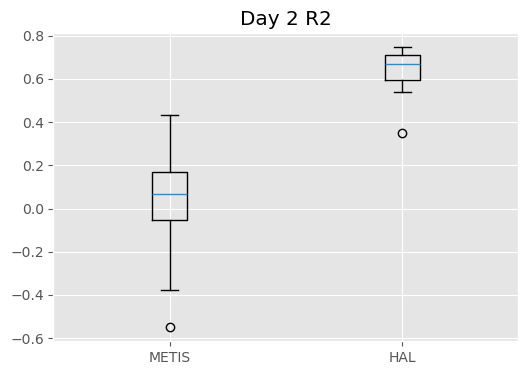

In [99]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_r2 = [METIS_day2_r2, HAL_day2_r2]
plt.boxplot(day2_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 R2")

t, p_value = stats.ttest_ind(METIS_day2_r2,HAL_day2_r2)
print(t, p_value)

In [196]:
METIS_day2_mae2, METIS_day2_pred2 = test_func(METIS_day2_params_list, scaled_METIS_day2_X_train, scaled_X_test_small, METIS_day2_y_train, y_test_small)
HAL_day2_mae2, HAL_day2_pred2 = test_func(HAL_day2_params_list, scaled_HAL_day2_X_train, scaled_X_test_small, HAL_day2_y_train,y_test_small)

t, p_value = stats.ttest_ind(METIS_day2_mae2,HAL_day2_mae2)
print(t, p_value)

METIS_day2_r2_2 = []
HAL_day2_r2_2 = []
for i in range(len(METIS_day2_pred2)):
    METIS_day2_r2_2.append(r2_score(y_test_small, METIS_day2_pred2[i]))
    HAL_day2_r2_2.append(r2_score(y_test_small, HAL_day2_pred2[i]))
    
print(np.mean(METIS_day2_r2_2))
print(np.mean(HAL_day2_r2_2))

t, p_value = stats.ttest_ind(METIS_day2_r2_2,HAL_day2_r2_2)
print(t, p_value)

Test score : 0.14078674335131927
Test score : 0.13528086132207598
1.2227226360064258 0.22896397511565927
0.6655959841923023
0.7047975437273692
-2.150129464945728 0.03797200251511911


#### Day3 recommend

In [488]:
sampling_num = 10
round_num = 5
day = 3
METIS_day3_recommend = METIS_recommendation(METIS_day2_params_list, scaled_METIS_day2_X_train, METIS_day2_y_train, scaled_ALL_possible_conditions, day)
#METIS_optim_day3_recommend = METIS_recommendation(METIS_day2_optim_params_list, scaled_METIS_day2_optim_X_train, METIS_day2_optim_y_train, scaled_ALL_possible_conditions, day, 'optimization')
#HAL_day3_recommend = HAL_recommendation(HAL_day2_params_list, scaled_HAL_day2_X_train, HAL_day2_y_train, scaled_ALL_possible_conditions, day)

1 0
[2674559, 1330556, 590655, 656959, 2674556, 657215, 1330044, 657471, 1330559, 590399] [2674559, 1330556, 590655, 656959, 2674556, 657215, 1330044, 657471, 1330559, 590399]


In [489]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
METIS_day3_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_day3_recommend), columns = col_list)
METIS_day3_optim_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_optim_day3_recommend), columns = col_list)
HAL_day3_recommend_df = pd.DataFrame(scaler.inverse_transform(HAL_day3_recommend), columns = col_list)

In [490]:
METIS_day3_recommend_transformed = transform_df(METIS_day3_recommend_df)
METIS_day3_optim_recommend_transformed = transform_df(METIS_day3_optim_recommend_df)
HAL_day3_recommend_transformed = transform_df(HAL_day3_recommend_df)

In [491]:
METIS_day3_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,5,3,5,3,0.25,1.0,1.0,1.0,1.0
1,2,5,3,5,3,0.25,1.0,1.0,1.0,0.1
2,1,3,3,2,3,0.10,1.0,1.0,1.0,1.0
3,1,5,3,4,2,0.10,1.0,1.0,1.0,1.0
4,4,5,3,5,3,0.25,1.0,1.0,1.0,0.1
5,1,5,3,4,3,0.10,1.0,1.0,1.0,1.0
6,2,5,3,5,1,0.25,1.0,1.0,1.0,0.1
7,1,5,3,4,4,0.10,1.0,1.0,1.0,1.0
8,2,5,3,5,3,0.25,1.0,1.0,1.0,1.0
9,1,3,3,2,2,0.10,1.0,1.0,1.0,1.0


In [245]:
METIS_day3_recommend_transformed.iloc[:, :5].value_counts()

Idi  ispA  CrtE  CrtB  CrtI
2    5     3     5     3       2
4    5     3     5     3       2
1    3     3     2     2       1
                       3       1
     5     3     4     3       1
                       2       1
2    5     3     5     1       1
1    5     3     4     4       1
Name: count, dtype: int64

In [477]:
HAL_day3_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,3,1,3,2,3,0.25,1.00,0.1,0.50,0.50
1,4,2,1,3,3,1.00,0.10,1.0,1.00,1.00
2,3,5,1,4,5,0.25,0.10,1.0,1.00,0.10
3,4,3,1,2,5,0.10,0.10,1.0,0.10,0.10
4,2,5,1,3,2,0.10,1.00,1.0,0.25,0.25
5,4,1,3,5,5,1.00,1.00,0.1,0.25,1.00
6,3,2,1,4,3,1.00,1.00,1.0,0.10,0.10
7,3,5,4,5,4,0.10,0.50,0.1,1.00,0.10
8,3,4,5,5,5,1.00,0.25,0.1,0.50,0.10
9,2,3,1,5,3,1.00,0.25,1.0,0.10,0.10


In [190]:
HAL_day3_recommend_transformed.iloc[:, :5].value_counts()

Idi  ispA  CrtE  CrtB  CrtI
0    3     1     4     2       1
2    5     1     3     2       1
3    1     3     2     3       1
     2     1     4     3       1
     4     5     5     5       1
     5     1     4     5       1
           4     5     4       1
4    1     3     5     5       1
     2     1     3     3       1
     3     1     2     5       1
Name: count, dtype: int64

In [265]:
#METIS_day3_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day3.csv', index = False)
METIS_day3_optim_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day3.csv', index = False)
#HAL_day3_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day3.csv', index = False)

#### Day4

In [60]:
# load data
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_METIS_param.json', 'r') as f:
#     day2_METIS_params_list = json.load(f)
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_HAL_param.json', 'r') as f:
#     day2_HAL_params_list = json.load(f)

In [306]:
METIS_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day3_result.csv')
METIS_day3_optim = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day3_result.csv')
HAL_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day3_result.csv')

METIS_day3_label = METIS_day3['result'].apply(lambda x: max(0, x))
METIS_day3.drop(columns = ['result'], inplace = True)

METIS_day3_optim_label = METIS_day3_optim['result'].apply(lambda x: max(0, x))
METIS_day3_optim.drop(columns = ['result'], inplace = True)

HAL_day3_label = HAL_day3['result'].apply(lambda x: max(0, x))
HAL_day3.drop(columns = ['result'], inplace = True)

col_list = METIS_day3.columns.tolist()

In [307]:
METIS_day3_processed, METIS_day3_label_processed = preprocess(METIS_day3, METIS_day3_label, col_list)
METIS_day3_optim_processed, METIS_day3_optim_label_processed = preprocess(METIS_day3_optim, METIS_day3_optim_label, col_list)
HAL_day3_processed, HAL_day3_label_processed = preprocess(HAL_day3, HAL_day3_label, col_list)

In [308]:
np.mean(METIS_day3_label_processed),np.mean(METIS_day3_optim_label_processed), np.mean(HAL_day3_label_processed)

(0.7178266179433332, 2.193406593333333, 0.9048840049200001)

In [309]:
METIS_day3_processed_onehot = make_onehot(METIS_day3_processed)
METIS_day3_optim_processed_onehot = make_onehot(METIS_day3_optim_processed)
HAL_day3_processed_onehot = make_onehot(HAL_day3_processed)

In [310]:
METIS_day2_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_x.csv')
METIS_day2_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_y.csv')

METIS_optim_day2_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day2_train_x.csv')
METIS_optim_day2_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day2_train_y.csv')

HAL_day2_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_x.csv')
HAL_day2_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_y.csv')

In [311]:
METIS_day3_X_train = pd.concat([METIS_day2_X_train, METIS_day3_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day3_y_train = pd.concat([METIS_day2_y_train['0'], METIS_day3_label_processed], axis = 0).reset_index(drop = True)

METIS_day3_optim_X_train = pd.concat([METIS_optim_day2_X_train, METIS_day3_optim_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day3_optim_y_train = pd.concat([METIS_optim_day2_y_train['0'], METIS_day3_optim_label_processed], axis = 0).reset_index(drop = True)

HAL_day3_X_train = pd.concat([HAL_day2_X_train, HAL_day3_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day3_y_train = pd.concat([HAL_day2_y_train['0'], HAL_day3_label_processed], axis = 0).reset_index(drop = True)

In [65]:
# METIS_day3_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_x.csv', index = False)
# METIS_day3_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_y.csv', index = False)

# METIS_day3_optim_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day3_train_x.csv', index = False)
# METIS_day3_optim_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day3_train_y.csv', index = False)

# HAL_day3_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_x.csv', index = False)
# HAL_day3_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_y.csv', index = False)

In [312]:
scaled_METIS_day3_X_train = scaler.transform(METIS_day3_X_train)
scaled_METIS_day3_optim_X_train = scaler.transform(METIS_day3_optim_X_train)
scaled_HAL_day3_X_train = scaler.transform(HAL_day3_X_train)

scaled_METIS_day3_X_train.shape,scaled_METIS_day3_optim_X_train.shape, scaled_HAL_day3_X_train.shape

((107, 29), (107, 29), (107, 29))

In [313]:
METIS_day3_params_list, METIS_day3_grid_results = optimize_param(scaled_METIS_day3_X_train, METIS_day3_y_train)
#METIS_day3_optim_params_list, METIS_day3_optim_grid_results = optimize_param(scaled_METIS_day3_optim_X_train, METIS_day3_optim_y_train)
HAL_day3_params_list, HAL_day3_grid_results = optimize_param(scaled_HAL_day3_X_train, HAL_day3_y_train)

0.29154019604839965
0.30498210891398775


-9.618726926025246 9.944570938872019e-12


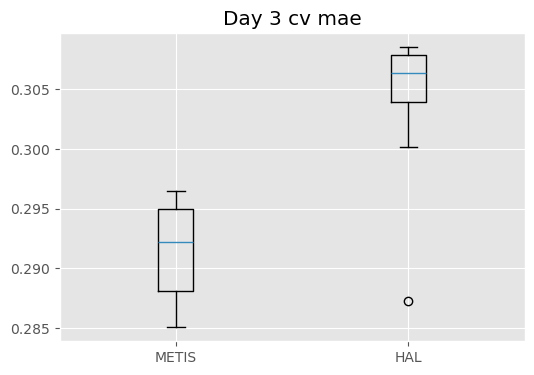

In [108]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day3_cv = [-1*METIS_day3_grid_results[:20], -1*HAL_day3_grid_results[:20]]
plt.boxplot(day3_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 3 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day3_grid_results[:20], -1*HAL_day3_grid_results[:20])
print(t, p_value)

In [109]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_METIS_param.json', 'w') as f:
    json.dump(METIS_day3_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_HAL_param.json', 'w') as f:
    json.dump(HAL_day3_params_list, f)

In [650]:
METIS_day3_cv_total = []
HAL_day3_cv_total = []
for i in range(20):
    xgb_reg_METIS = XGBRegressor(**day2_METIS_params_list[i], n_estimators = 500)
    xgb_reg_HAL = XGBRegressor(**day2_HAL_params_list[i], n_estimators = 500)
    METIS_cv_scores = cross_val_score(xgb_reg_METIS, scaled_METIS_day3_X_train, METIS_day3_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    HAL_cv_scores = cross_val_score(xgb_reg_HAL, scaled_HAL_day3_X_train, HAL_day3_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    METIS_day3_cv_total.append(np.mean(METIS_cv_scores))
    HAL_day3_cv_total.append(np.mean(HAL_cv_scores))
np.mean(METIS_day3_cv_total), np.mean(HAL_day3_cv_total)

(0.3371139252867973, 0.3199909993991694)

In [314]:
METIS_day3_mae, METIS_day3_pred = test_func(METIS_day3_params_list, scaled_METIS_day3_X_train, scaled_X_test, METIS_day3_y_train, random_label_processed)
HAL_day3_mae, HAL_day3_pred = test_func(HAL_day3_params_list, scaled_HAL_day3_X_train, scaled_X_test, HAL_day3_y_train, random_label_processed)

Test score : 0.4220651401718838
Test score : 0.2876457205806133


In [315]:
M3_std_test = np.mean(np.std(METIS_day3_pred, axis = 0))
H3_std_test = np.mean(np.std(HAL_day3_pred, axis = 0))

M3_std_test, H3_std_test

(0.15775837, 0.12255711)

15.803531942070347 2.7093133952235765e-18


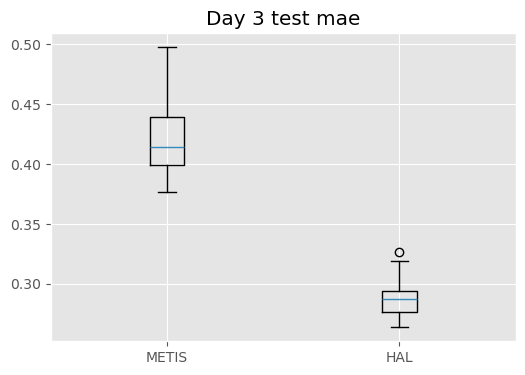

In [111]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day3_mae = [METIS_day3_mae, HAL_day3_mae]
plt.boxplot(day3_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 3 test mae")

t, p_value = stats.ttest_ind(METIS_day3_mae,HAL_day3_mae)
print(t, p_value)

In [112]:
METIS_day3_r2 = []
HAL_day3_r2 = []
for i in range(len(METIS_day3_pred)):
    METIS_day3_r2.append(r2_score(random_label_processed, METIS_day3_pred[i]))
    HAL_day3_r2.append(r2_score(random_label_processed, HAL_day3_pred[i]))
print(np.mean(METIS_day3_r2))
print(np.mean(HAL_day3_r2))

0.2483366905371942
0.6400036543720519


-14.415156074722717 5.478203542438171e-17


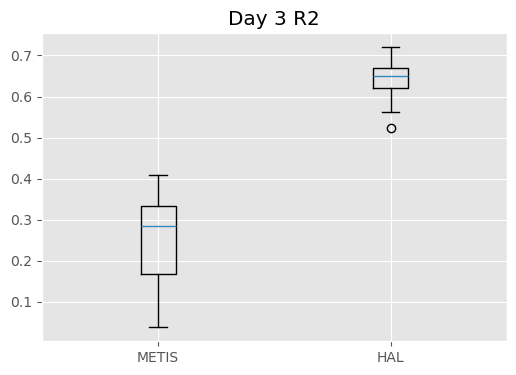

In [113]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day3_r2 = [METIS_day3_r2, HAL_day3_r2]
plt.boxplot(day3_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 3 R2")

t, p_value = stats.ttest_ind(METIS_day3_r2,HAL_day3_r2)
print(t, p_value)

In [197]:
METIS_day3_mae2, METIS_day3_pred2 = test_func(METIS_day3_params_list, scaled_METIS_day3_X_train, scaled_X_test_small, METIS_day3_y_train, y_test_small)
HAL_day3_mae2, HAL_day3_pred2 = test_func(HAL_day3_params_list, scaled_HAL_day3_X_train, scaled_X_test_small, HAL_day3_y_train, y_test_small)

t, p_value = stats.ttest_ind(METIS_day3_mae2,HAL_day3_mae2)
print(t, p_value)

METIS_day3_r2_2 = []
HAL_day3_r2_2 = []
for i in range(len(METIS_day3_pred2)):
    METIS_day3_r2_2.append(r2_score(y_test_small, METIS_day3_pred2[i]))
    HAL_day3_r2_2.append(r2_score(y_test_small, HAL_day3_pred2[i]))
    
print(np.mean(METIS_day3_r2_2))
print(np.mean(HAL_day3_r2_2))

t, p_value = stats.ttest_ind(METIS_day3_r2_2,HAL_day3_r2_2)
print(t, p_value)

Test score : 0.16471614872265086
Test score : 0.1459983688556964
3.1391362175809 0.003271619634424493
0.5571227901790532
0.6371873849152707
-2.942785817726552 0.005518349307423737


#### Day4 recommend

In [666]:
sampling_num = 10
round_num = 5
day = 4
METIS_day4_recommend = METIS_recommendation(METIS_day3_params_list, scaled_METIS_day3_X_train, METIS_day3_y_train, scaled_ALL_possible_conditions, day)
METIS_optim_day4_recommend = METIS_recommendation(METIS_day3_optim_params_list, scaled_METIS_day3_optim_X_train, METIS_day3_optim_y_train, scaled_ALL_possible_conditions, day, 'optimization')
HAL_day4_recommend = HAL_recommendation(HAL_day3_params_list, scaled_HAL_day3_X_train, HAL_day3_y_train, scaled_ALL_possible_conditions, day)

1 0
[500080, 500144, 501360, 660080, 500208, 500084, 660144, 500088, 660208, 661360] [500080, 500144, 501360, 660080, 500208, 500084, 660144, 500088, 660208, 661360]
1.0 1
[2295873, 2289473, 2295877, 1623873, 1623877, 2289409, 2295809, 2289477, 2295874, 2295813] [2295873, 2295877, 1623873, 1623877, 2289409, 2295809, 2295874, 2295813, 1623809, 2295878]
0.6 0.4


100%|██████████| 2688000/2688000 [19:39<00:00, 2277.98it/s]


[[0.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         0.         1.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.16666667 1.         0.         0.16666667 0.        ]]


100%|██████████| 2687999/2687999 [19:37<00:00, 2283.08it/s]


[[0.         0.         1.         0.         0.         0.
  0.         0.         1.         0.         0.         1.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         1.         0.         0.16666667 1.        ]]


100%|██████████| 2687998/2687998 [19:46<00:00, 2265.06it/s]


[[1.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         0.         0.         1.         0.         0.
  0.         0.         0.         1.         0.         0.
  1.         1.         1.         1.         0.44444444]]


100%|██████████| 2687997/2687997 [19:52<00:00, 2253.86it/s]


[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 1. 0. 1. 0.]]


100%|██████████| 2687996/2687996 [20:08<00:00, 2224.45it/s]


[[0.         1.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         0.         0.
  0.44444444 0.25       0.         1.         1.        ]]


100%|██████████| 2687995/2687995 [20:18<00:00, 2206.66it/s]


[[1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  1.  0.1 1.  1.  1. ]]


100%|██████████| 2687994/2687994 [20:39<00:00, 2167.76it/s]


[[1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.16666667 0.1        0.         0.16666667 0.        ]]


100%|██████████| 2687993/2687993 [20:51<00:00, 2147.55it/s]


[[1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  1.         1.         0.         0.44444444 1.        ]]


100%|██████████| 2687992/2687992 [20:52<00:00, 2145.68it/s]


[[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 1. 1.]]


100%|██████████| 2687991/2687991 [21:01<00:00, 2131.36it/s]


[[0.         1.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.25       0.16666667 0.16666667 1.        ]]


In [667]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
METIS_day4_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_day4_recommend), columns = col_list)
METIS_day4_optim_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_optim_day4_recommend), columns = col_list)
HAL_day4_recommend_df = pd.DataFrame(scaler.inverse_transform(HAL_day4_recommend), columns = col_list)

In [668]:
METIS_day4_recommend_transformed = transform_df(METIS_day4_recommend_df)
METIS_day4_optim_recommend_transformed = transform_df(METIS_day4_optim_recommend_df)
HAL_day4_recommend_transformed = transform_df(HAL_day4_recommend_df)

In [691]:
METIS_day4_optim_recommend_transformed 

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,3,4,4,4,0.25,0.25,0.1,0.10,0.25
1,4,3,3,4,4,0.25,0.25,0.1,0.10,0.25
2,4,3,4,4,4,0.25,0.25,0.1,0.25,0.25
3,3,3,4,4,4,0.25,0.25,0.1,0.10,0.25
4,3,3,4,4,4,0.25,0.25,0.1,0.25,0.25
5,4,3,3,4,4,0.10,0.25,0.1,0.10,0.25
6,4,3,4,4,4,0.10,0.25,0.1,0.10,0.25
7,4,3,3,4,4,0.25,0.25,0.1,0.25,0.25
8,4,3,4,4,4,0.25,0.25,0.1,0.10,0.50
9,4,3,4,4,4,0.10,0.25,0.1,0.25,0.25


In [669]:
HAL_day4_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,3,3,1,4,0.25,1.00,0.10,0.25,0.1
1,3,5,3,1,5,0.10,1.00,0.10,0.25,1.0
2,1,3,4,2,3,1.00,1.00,1.00,1.00,0.5
3,1,4,3,1,5,1.00,1.00,0.10,1.00,0.1
4,2,1,3,3,2,0.50,0.25,0.10,1.00,1.0
5,1,4,1,4,2,1.00,0.10,1.00,1.00,1.0
6,1,2,3,4,5,0.25,0.10,0.10,0.25,0.1
7,1,2,3,1,4,1.00,1.00,0.10,0.50,1.0
8,3,1,4,1,4,1.00,1.00,0.10,1.00,1.0
9,2,2,4,3,1,0.10,0.25,0.25,0.25,1.0


In [678]:
df_tmp = pd.concat([make_onehot(METIS_day4_optim_recommend_transformed),METIS_day3_optim_X_train], axis = 0)

In [680]:
df_tmp

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.25,0.10,0.10,0.25
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.25,0.10,0.10,0.25
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.25,0.10,0.25,0.25
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.25,0.10,0.10,0.25
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.25,0.10,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0.50,0.50,0.10,0.25,0.25
103,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0.50,0.50,0.10,0.25,0.25
104,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.50,0.50,0.10,0.25,0.25
105,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0.50,0.50,0.25,0.25,0.25


In [ ]:
METIS_day4_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day4.csv', index = False)
METIS_day4_optim_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day4.csv', index = False)
HAL_day4_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day4.csv', index = False)

#### Day 5

In [76]:
# load data
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_METIS_param.json', 'r') as f:
#     day3_METIS_params_list = json.load(f)
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_HAL_param.json', 'r') as f:
#     day3_HAL_params_list = json.load(f)

In [316]:
METIS_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day4_result.csv')
METIS_day4_optim = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day4_result.csv')
HAL_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day4_result.csv')

METIS_day4_label = METIS_day4['result'].apply(lambda x: max(0, x))
METIS_day4.drop(columns = ['result'], inplace = True)

METIS_day4_optim_label = METIS_day4_optim['result'].apply(lambda x: max(0, x))
METIS_day4_optim.drop(columns = ['result'], inplace = True)

HAL_day4_label = HAL_day4['result'].apply(lambda x: max(0, x))
HAL_day4.drop(columns = ['result'], inplace = True)

col_list = METIS_day4.columns.tolist()

In [317]:
METIS_day4_processed, METIS_day4_label_processed = preprocess(METIS_day4, METIS_day4_label, col_list)
METIS_day4_optim_processed, METIS_day4_optim_label_processed = preprocess(METIS_day4_optim, METIS_day4_optim_label, col_list)
HAL_day4_processed, HAL_day4_label_processed = preprocess(HAL_day4, HAL_day4_label, col_list)

In [318]:
np.mean(METIS_day4_label_processed),np.mean(METIS_day4_optim_label_processed), np.mean(HAL_day4_label_processed)

(1.5720000003333334, 2.5724444447666666, 1.5722222225233335)

In [319]:
METIS_day4_processed_onehot = make_onehot(METIS_day4_processed)
METIS_day4_optim_processed_onehot = make_onehot(METIS_day4_optim_processed)
HAL_day4_processed_onehot = make_onehot(HAL_day4_processed)

In [320]:
METIS_day3_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_x.csv')
METIS_day3_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_y.csv')

METIS_optim_day3_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day3_train_x.csv')
METIS_optim_day3_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day3_train_y.csv')

HAL_day3_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_x.csv')
HAL_day3_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_y.csv')

In [321]:
METIS_day3_X_train.shape, METIS_optim_day3_X_train.shape, HAL_day3_X_train.shape

((107, 29), (107, 29), (107, 29))

In [322]:
METIS_day4_X_train = pd.concat([METIS_day3_X_train, METIS_day4_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day4_y_train = pd.concat([METIS_day3_y_train['0'], METIS_day4_label_processed], axis = 0).reset_index(drop = True)

METIS_day4_optim_X_train = pd.concat([METIS_optim_day3_X_train, METIS_day4_optim_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day4_optim_y_train = pd.concat([METIS_optim_day3_y_train['0'], METIS_day4_optim_label_processed], axis = 0).reset_index(drop = True)

HAL_day4_X_train = pd.concat([HAL_day3_X_train, HAL_day4_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day4_y_train = pd.concat([HAL_day3_y_train['0'], HAL_day4_label_processed], axis = 0).reset_index(drop = True)

In [81]:
# METIS_day4_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_x.csv', index = False)
# METIS_day4_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_y.csv', index = False)

# METIS_day4_optim_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day4_train_x.csv', index = False)
# METIS_day4_optim_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day4_train_y.csv', index = False)

# HAL_day4_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_x.csv', index = False)
# HAL_day4_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_y.csv', index = False)

In [323]:
scaled_METIS_day4_X_train = scaler.transform(METIS_day4_X_train)
scaled_METIS_day4_optim_X_train = scaler.transform(METIS_day4_optim_X_train)
scaled_HAL_day4_X_train = scaler.transform(HAL_day4_X_train)

scaled_METIS_day4_X_train.shape,scaled_METIS_day4_optim_X_train.shape, scaled_HAL_day4_X_train.shape

((117, 29), (117, 29), (117, 29))

In [324]:
METIS_day4_params_list, METIS_day4_grid_results = optimize_param(scaled_METIS_day4_X_train, METIS_day4_y_train)
#METIS_day4_optim_params_list, METIS_day4_optim_grid_results = optimize_param(scaled_METIS_day4_optim_X_train, METIS_day4_optim_y_train)
HAL_day4_params_list, HAL_day4_grid_results = optimize_param(HAL_day4_X_train, HAL_day4_y_train)

0.28109338822127394
0.32053587547448326


-22.923267725434098 7.461448468947097e-24


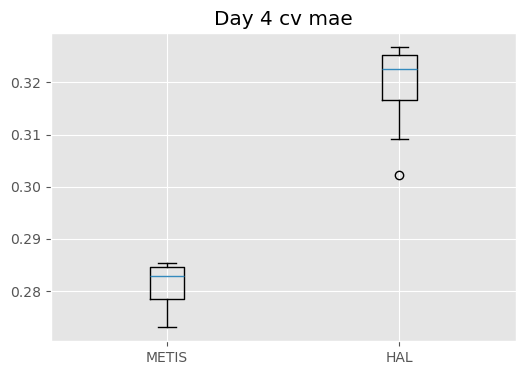

In [124]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day4_cv = [-1*METIS_day4_grid_results[:20], -1*HAL_day4_grid_results[:20]]
plt.boxplot(day4_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 4 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day4_grid_results[:20], -1*HAL_day4_grid_results[:20])
print(t, p_value)

In [125]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day4_METIS_param.json', 'w') as f:
    json.dump(METIS_day4_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day4_HAL_param.json', 'w') as f:
    json.dump(HAL_day4_params_list, f)

In [325]:
METIS_day4_mae, METIS_day4_pred = test_func(METIS_day4_params_list, scaled_METIS_day4_X_train, scaled_X_test, METIS_day4_y_train, random_label_processed)
HAL_day4_mae, HAL_day4_pred = test_func(HAL_day4_params_list, scaled_HAL_day4_X_train, scaled_X_test, HAL_day4_y_train, random_label_processed)

Test score : 0.41480427745545434
Test score : 0.2857185438065994


In [326]:
M4_std_test = np.mean(np.std(METIS_day4_pred, axis = 0))
H4_std_test = np.mean(np.std(HAL_day4_pred, axis = 0))

M4_std_test, H4_std_test

(0.16672663, 0.13654408)

12.276166697489238 8.53801569120042e-15


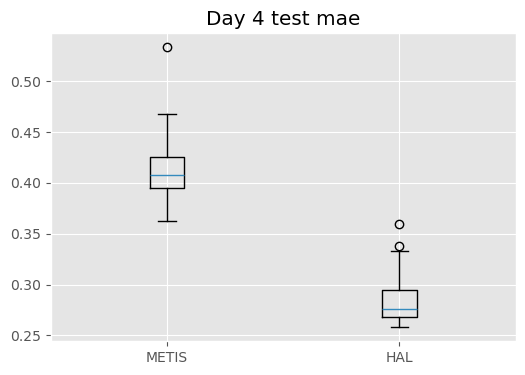

In [127]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day4_mae = [METIS_day4_mae, HAL_day4_mae]
plt.boxplot(day4_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 4 test mae")

t, p_value = stats.ttest_ind(METIS_day4_mae,HAL_day4_mae)
print(t, p_value)

In [128]:
METIS_day4_r2 = []
HAL_day4_r2 = []
for i in range(len(METIS_day4_pred)):
    METIS_day4_r2.append(r2_score(random_label_processed, METIS_day4_pred[i]))
    HAL_day4_r2.append(r2_score(random_label_processed, HAL_day4_pred[i]))
print(np.mean(METIS_day4_r2))
print(np.mean(HAL_day4_r2))

0.27996263813316435
0.6293823530864958


-11.432082871339896 7.287476834477816e-14


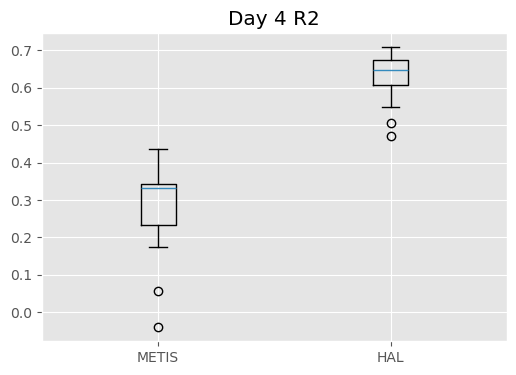

In [129]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day4_r2 = [METIS_day4_r2, HAL_day4_r2]
plt.boxplot(day4_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 4 R2")

t, p_value = stats.ttest_ind(METIS_day4_r2,HAL_day4_r2)
print(t, p_value)

In [198]:
METIS_day4_mae2, METIS_day4_pred2 = test_func(METIS_day4_params_list, scaled_METIS_day4_X_train, scaled_X_test_small, METIS_day4_y_train, y_test_small)
HAL_day4_mae2, HAL_day4_pred2 = test_func(HAL_day4_params_list, scaled_HAL_day4_X_train, scaled_X_test_small, HAL_day4_y_train, y_test_small)

t, p_value = stats.ttest_ind(METIS_day4_mae2,HAL_day4_mae2)
print(t, p_value)

METIS_day4_r2_2 = []
HAL_day4_r2_2 = []
for i in range(len(METIS_day4_pred2)):
    METIS_day4_r2_2.append(r2_score( y_test_small, METIS_day4_pred2[i]))
    HAL_day4_r2_2.append(r2_score( y_test_small, HAL_day4_pred2[i]))
    
print(np.mean(METIS_day4_r2_2))
print(np.mean(HAL_day4_r2_2))

t, p_value = stats.ttest_ind(METIS_day4_r2_2,HAL_day4_r2_2)
print(t, p_value)

Test score : 0.15384733210678206
Test score : 0.1669981323239718
-1.905587748204841 0.06429022216275078
0.6194269275672426
0.573831164907036
1.4365417072492477 0.15903083034549095


#### Day5 recommend

In [130]:
sampling_num = 10
round_num = 5
day = 5
METIS_day5_recommend = METIS_recommendation(METIS_day4_params_list, scaled_METIS_day4_X_train, METIS_day4_y_train, scaled_ALL_possible_conditions, day)
#METIS_optim_day5_recommend = METIS_recommendation(METIS_day4_optim_params_list, scaled_METIS_day4_optim_X_train, METIS_day4_optim_y_train, scaled_ALL_possible_conditions, day, 'optimization')
HAL_day5_recommend = HAL_recommendation(HAL_day4_params_list, scaled_HAL_day4_X_train, HAL_day4_y_train, scaled_ALL_possible_conditions, day)

1 0
[352118, 205888, 352114, 192118, 352122, 365888, 1696123, 1696118, 192114, 32118] [352118, 205888, 352114, 192118, 352122, 365888, 1696123, 1696118, 192114, 32118]
0.5 0.5


100%|██████████| 2688000/2688000 [21:14<00:00, 2109.79it/s]


[[1.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.44444444 0.1        0.16666667 0.         0.16666667]]


100%|██████████| 2687999/2687999 [21:45<00:00, 2059.77it/s]


[[0.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         1.         0.         0.         0.         0.
  1.         0.25       0.44444444 1.         0.44444444]]


100%|██████████| 2687998/2687998 [21:38<00:00, 2070.38it/s]


[[0.         0.         1.         0.         0.         0.
  1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  1.         1.         0.         0.         0.         0.
  0.16666667 1.         0.         0.16666667 0.        ]]


100%|██████████| 2687997/2687997 [21:54<00:00, 2044.19it/s]


[[1.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  1.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         1.         0.
  1.         0.25       0.16666667 1.         1.        ]]


100%|██████████| 2687996/2687996 [21:59<00:00, 2037.81it/s]


[[0.         0.         1.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         1.         0.         0.         0.         0.
  0.16666667 0.1        1.         0.         0.44444444]]


100%|██████████| 2687995/2687995 [22:28<00:00, 1993.38it/s]


[[0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         1.
  0.         0.         0.         0.         1.         0.
  0.16666667 0.         0.44444444 1.         0.16666667]]


100%|██████████| 2687994/2687994 [22:22<00:00, 2002.54it/s]


[[1.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  1.         0.1        0.16666667 0.44444444 0.44444444]]


100%|██████████| 2687993/2687993 [22:47<00:00, 1964.94it/s]


[[0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  1.  0.1 1.  0.  1. ]]


100%|██████████| 2687992/2687992 [22:52<00:00, 1959.14it/s]


[[1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         1.         0.
  0.         0.         1.         0.         0.         0.
  0.44444444 1.         0.         1.         1.        ]]


100%|██████████| 2687991/2687991 [23:18<00:00, 1921.97it/s]


[[1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         0.         1.         0.         0.         0.
  0.16666667 0.1        1.         0.         0.16666667]]


In [131]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
METIS_day5_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_day5_recommend), columns = col_list)
#METIS_day5_optim_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_optim_day5_recommend), columns = col_list)
HAL_day5_recommend_df = pd.DataFrame(scaler.inverse_transform(HAL_day5_recommend), columns = col_list)

In [143]:
HAL_day5_recommend_df

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.50,0.10,0.25,0.10,0.25
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.00,0.25,0.50,1.00,0.50
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.25,1.00,0.10,0.25,0.10
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.00,0.25,0.25,1.00,1.00
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.25,0.10,1.00,0.10,0.50
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.25,0.00,0.50,1.00,0.25
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.00,0.10,0.25,0.50,0.50
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.00,0.10,1.00,0.10,1.00
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.50,1.00,0.10,1.00,1.00
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.25,0.10,1.00,0.10,0.25


In [148]:
METIS_day5_recommend_transformed = transform_df(METIS_day5_recommend_df)
#METIS_day5_optim_recommend_transformed = transform_df(METIS_day5_optim_recommend_df)
HAL_day5_recommend_transformed = transform_df(HAL_day5_recommend_df)

In [149]:
HAL_day5_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1,4,4,2,4,0.50,0.10,0.25,0.10,0.25
1,4,3,4,5,1,1.00,0.25,0.50,1.00,0.50
2,3,3,3,5,1,0.25,1.00,0.10,0.25,0.10
3,1,5,4,3,4,1.00,0.25,0.25,1.00,1.00
4,3,4,4,5,1,0.25,0.10,1.00,0.10,0.50
5,4,0,5,4,4,0.25,0.00,0.50,1.00,0.25
6,1,3,4,1,4,1.00,0.10,0.25,0.50,0.50
7,2,1,2,4,5,1.00,0.10,1.00,0.10,1.00
8,1,2,5,3,2,0.50,1.00,0.10,1.00,1.00
9,1,2,4,5,2,0.25,0.10,1.00,0.10,0.25


In [150]:
METIS_day5_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day5.csv', index = False)
#METIS_day5_optim_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day5.csv', index = False)
HAL_day5_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day5.csv', index = False)

#### Day 5 analysis

In [13]:
METIS_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day5_result.csv')
METIS_day5_optim = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_optim_Day5_result_ctr_mean.csv')
HAL_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day5_result.csv')

METIS_day5_label = METIS_day5['result'].apply(lambda x: max(0, x))
METIS_day5.drop(columns = ['result'], inplace = True)

METIS_day5_optim_label = METIS_day5_optim['result'].apply(lambda x: max(0, x))
METIS_day5_optim.drop(columns = ['result'], inplace = True)

HAL_day5_label = HAL_day5['result'].apply(lambda x: max(0, x))
HAL_day5.drop(columns = ['result'], inplace = True)

col_list = METIS_day5.columns.tolist()

In [14]:
METIS_day5_processed, METIS_day5_label_processed = preprocess(METIS_day5, METIS_day5_label, col_list)
METIS_day5_optim_processed, METIS_day5_optim_label_processed = preprocess(METIS_day5_optim, METIS_day5_optim_label, col_list)
HAL_day5_processed, HAL_day5_label_processed = preprocess(HAL_day5, HAL_day5_label, col_list)

In [15]:
np.mean(METIS_day5_label_processed),np.mean(METIS_day5_optim_label_processed), np.mean(HAL_day5_label_processed) 

(0.8291970803, 2.7248157248666667, 0.6700729927333333)

In [16]:
METIS_day5_processed_onehot = make_onehot(METIS_day5_processed)
METIS_day5_optim_processed_onehot = make_onehot(METIS_day5_optim_processed)
HAL_day5_processed_onehot = make_onehot(HAL_day5_processed)

In [17]:
METIS_day4_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_x.csv')
METIS_day4_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_y.csv')

METIS_optim_day4_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day4_train_x.csv')
METIS_optim_day4_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day4_train_y.csv')

HAL_day4_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_x.csv')
HAL_day4_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_y.csv')

In [18]:
METIS_day4_X_train.shape, HAL_day4_X_train.shape # , METIS_optim_day4_X_train.shape

((117, 29), (117, 29))

In [19]:
METIS_day5_X_train = pd.concat([METIS_day4_X_train, METIS_day5_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day5_y_train = pd.concat([METIS_day4_y_train['0'], METIS_day5_label_processed], axis = 0).reset_index(drop = True)

METIS_day5_optim_X_train = pd.concat([METIS_optim_day4_X_train, METIS_day5_optim_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day5_optim_y_train = pd.concat([METIS_optim_day4_y_train['0'], METIS_day5_optim_label_processed], axis = 0).reset_index(drop = True)

HAL_day5_X_train = pd.concat([HAL_day4_X_train, HAL_day5_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day5_y_train = pd.concat([HAL_day4_y_train['0'], HAL_day5_label_processed], axis = 0).reset_index(drop = True)

In [20]:
METIS_day5_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day5_train_x.csv', index = False)
METIS_day5_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day5_train_y.csv', index = False)

METIS_day5_optim_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day5_train_x.csv', index = False)
METIS_day5_optim_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_optim_Day5_train_y.csv', index = False)

HAL_day5_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day5_train_x.csv', index = False)
HAL_day5_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day5_train_y.csv', index = False)

In [21]:
scaled_METIS_day5_X_train = scaler.transform(METIS_day5_X_train)
#scaled_METIS_day5_optim_X_train = scaler.transform(METIS_day5_optim_X_train)
scaled_HAL_day5_X_train = scaler.transform(HAL_day5_X_train)

scaled_METIS_day5_X_train.shape, scaled_HAL_day5_X_train.shape #,scaled_METIS_day5_optim_X_train.shape

((127, 29), (127, 29))

In [22]:
METIS_day5_params_list, METIS_day5_grid_results = optimize_param(scaled_METIS_day5_X_train, METIS_day5_y_train)
#METIS_day5_optim_params_list, METIS_day5_optim_grid_results = optimize_param(scaled_METIS_day5_optim_X_train, METIS_day5_optim_y_train)
HAL_day5_params_list, HAL_day5_grid_results = optimize_param(scaled_HAL_day5_X_train, HAL_day5_y_train)

0.2934967067003451
0.3024718374789669


-5.402977403972376 3.7486206613492845e-06


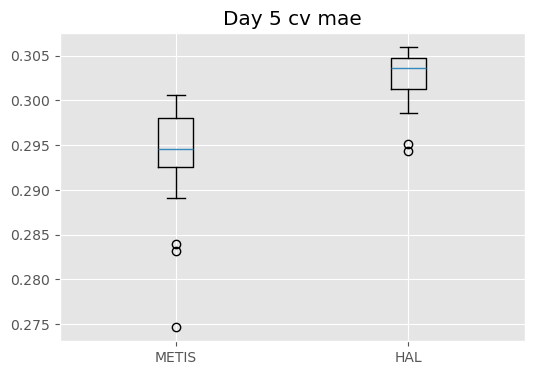

In [51]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day5_cv = [-1*METIS_day5_grid_results[:20], -1*HAL_day5_grid_results[:20]]
plt.boxplot(day5_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 5 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day5_grid_results[:20], -1*HAL_day5_grid_results[:20])
print(t, p_value)


In [165]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day5_METIS_param.json', 'w') as f:
    json.dump(METIS_day5_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day5_HAL_param.json', 'w') as f:
    json.dump(HAL_day5_params_list, f)

In [328]:
METIS_day5_mae, METIS_day5_pred = test_func(METIS_day5_params_list, scaled_METIS_day5_X_train, scaled_X_test, METIS_day5_y_train, random_label_processed)
HAL_day5_mae, HAL_day5_pred = test_func(HAL_day5_params_list, scaled_HAL_day5_X_train, scaled_X_test, HAL_day5_y_train, random_label_processed)

Test score : 0.46647030822820285
Test score : 0.28693652715300566


In [329]:
M5_std_test = np.mean(np.std(METIS_day5_pred, axis = 0))
H5_std_test = np.mean(np.std(HAL_day5_pred, axis = 0))

M5_std_test, H5_std_test

(0.19490089, 0.07763095)

20.47917146099408 3.9570537665311426e-22


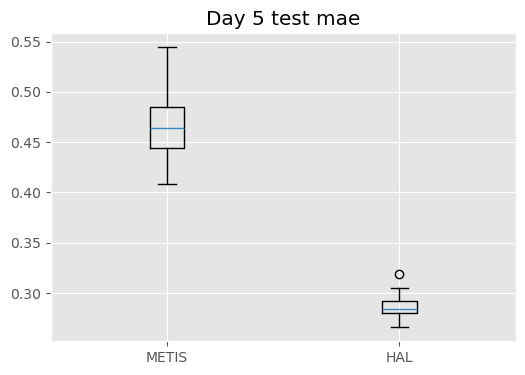

In [203]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day5_mae = [METIS_day5_mae, HAL_day5_mae]
plt.boxplot(day5_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 5 test mae")

t, p_value = stats.ttest_ind(METIS_day5_mae,HAL_day5_mae)
print(t, p_value)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HAL vs. METIS: t-test independent samples, P_val:3.957e-22 t=-2.048e+01


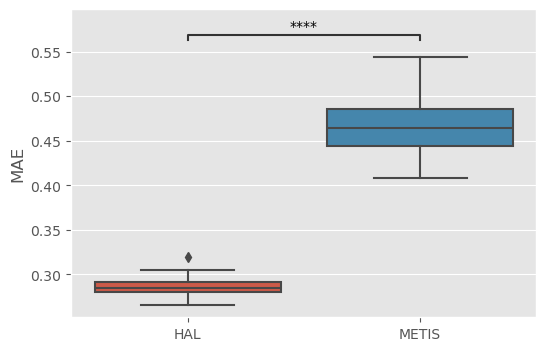

In [337]:
data = pd.DataFrame({
    '': ['HAL']*20 + ['METIS']*20,
    'MAE': np.concatenate([HAL_day5_mae, METIS_day5_mae])
})

# 박스 플롯 생성
plt.figure(figsize = (6,4))
ax = sns.boxplot(x="", y="MAE", data=data)

# 비교할 모델 쌍 정의
pairs = [("HAL", "METIS")]

# 주석 추가
annotator = Annotator(ax, pairs, data=data, x="", y="MAE")
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.savefig('plot/Experiment_day5_mae.png', bbox_inches='tight', dpi = 300)
# 플롯 출력
plt.show()

In [107]:
METIS_day5_r2 = []
HAL_day5_r2 = []
for i in range(len(METIS_day5_pred)):
    METIS_day5_r2.append(r2_score(random_label_processed, METIS_day5_pred[i]))
    HAL_day5_r2.append(r2_score(random_label_processed, HAL_day5_pred[i]))
print(np.mean(METIS_day5_r2))
print(np.mean(HAL_day5_r2))

0.10024669977235534
0.6198351807037831


-16.57836398151845 5.5021388803003825e-19


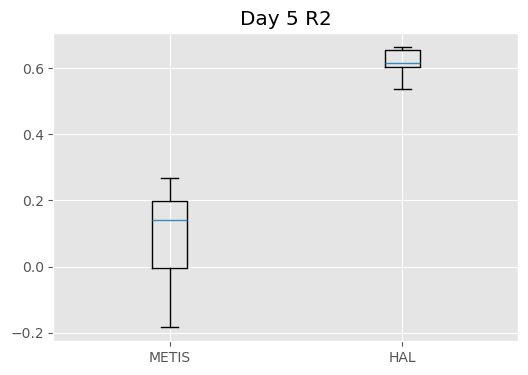

In [169]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day5_r2 = [METIS_day5_r2, HAL_day5_r2]
plt.boxplot(day5_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 5 R2")

t, p_value = stats.ttest_ind(METIS_day5_r2,HAL_day5_r2)
print(t, p_value)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HAL vs. METIS: t-test independent samples, P_val:5.502e-19 t=1.658e+01


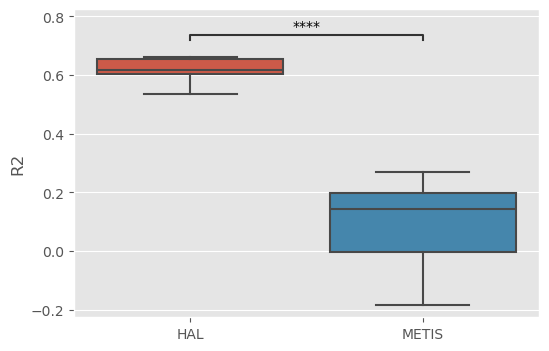

In [336]:
data = pd.DataFrame({
    '': ['HAL']*20 + ['METIS']*20,
    'R2': np.concatenate([HAL_day5_r2, METIS_day5_r2])
})
plt.figure(figsize = (6,4))
# 박스 플롯 생성
ax = sns.boxplot(x="", y="R2", data=data)

# 비교할 모델 쌍 정의
pairs = [("HAL", "METIS")]

# 주석 추가
annotator = Annotator(ax, pairs, data=data, x="", y="R2")
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('plot/Experiment_day5_r2.png', bbox_inches='tight', dpi = 300)
# 플롯 출력
plt.show()

#### Variation

In [231]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day0_param.json', 'r') as f:
    day0_params_list = json.load(f)

In [232]:
day0_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_x.csv')
day0_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_y.csv')

METIS_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1_result.csv')
HAL_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1_result.csv')

METIS_day1_label = METIS_day1['result'].apply(lambda x: max(0, x))
METIS_day1.drop(columns = ['result'], inplace = True)

HAL_day1_label = HAL_day1['result'].apply(lambda x: max(0, x))
HAL_day1.drop(columns = ['result'], inplace = True)

col_list = METIS_day1.columns.tolist()

METIS_day1_processed, METIS_day1_label_processed = preprocess(METIS_day1, METIS_day1_label, col_list)
HAL_day1_processed, HAL_day1_label_processed = preprocess(HAL_day1, HAL_day1_label, col_list)

METIS_day1_processed_onehot = make_onehot(METIS_day1_processed)
HAL_day1_processed_onehot = make_onehot(HAL_day1_processed)

scaled_day0_X_train = scaler.transform(day0_X_train)

scaled_METIS_day1_new = scaler.transform(METIS_day1_processed_onehot)
scaled_HAL_day1_new = scaler.transform(HAL_day1_processed_onehot)

scaled_day0_X_train.shape, scaled_METIS_day1_new.shape, scaled_HAL_day1_new.shape

In [255]:
METIS_day1_pred = []
HAL_day1_pred = []

for p in day0_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_day0_X_train, day0_y_train)
    pred_M = model_for_variation.predict(scaled_METIS_day1_new)
    pred_H = model_for_variation.predict(scaled_HAL_day1_new)
    METIS_day1_pred.append(pred_M)
    HAL_day1_pred.append(pred_H)
    
METIS_day1_std = np.std(METIS_day1_pred, axis = 0)
HAL_day1_std = np.std(HAL_day1_pred, axis = 0)

M1_std_mean = np.mean(METIS_day1_std)
H1_std_mean = np.mean(HAL_day1_std)

In [228]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_HAL_param.json', 'r') as f:
    HAL_day1_params_list = json.load(f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_METIS_param.json', 'r') as f:
    METIS_day1_params_list = json.load(f)

In [241]:
METIS_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_x.csv')
METIS_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_y.csv')

HAL_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_x.csv')
HAL_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_y.csv')

METIS_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2_result.csv')
HAL_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2_result.csv')

METIS_day2_label = METIS_day2['result'].apply(lambda x: max(0, x))
METIS_day2.drop(columns = ['result'], inplace = True)

HAL_day2_label = HAL_day2['result'].apply(lambda x: max(0, x))
HAL_day2.drop(columns = ['result'], inplace = True)

METIS_day2_processed, METIS_day2_label_processed = preprocess(METIS_day2, METIS_day2_label, col_list)
HAL_day2_processed, HAL_day2_label_processed = preprocess(HAL_day2, HAL_day2_label, col_list)

METIS_day2_processed_onehot = make_onehot(METIS_day2_processed)
HAL_day2_processed_onehot = make_onehot(HAL_day2_processed)

scaled_METIS_day1_X_train = scaler.transform(METIS_day1_X_train)
scaled_HAL_day1_X_train = scaler.transform(HAL_day1_X_train)

scaled_METIS_day2_new = scaler.transform(METIS_day2_processed_onehot)
scaled_HAL_day2_new = scaler.transform(HAL_day2_processed_onehot)

scaled_METIS_day1_X_train.shape, scaled_HAL_day1_X_train.shape, scaled_METIS_day2_new.shape, scaled_HAL_day2_new.shape

((87, 29), (87, 29), (10, 29), (10, 29))

In [256]:
METIS_day2_pred = []
HAL_day2_pred = []

for p in METIS_day1_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_METIS_day1_X_train, METIS_day1_y_train)
    pred_M = model_for_variation.predict(scaled_METIS_day2_new)
    METIS_day2_pred.append(pred_M)
for p in HAL_day1_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_HAL_day1_X_train, HAL_day1_y_train)
    pred_H = model_for_variation.predict(scaled_HAL_day2_new)
    HAL_day2_pred.append(pred_H)
    
METIS_day2_std = np.std(METIS_day2_pred, axis = 0)
HAL_day2_std = np.std(HAL_day2_pred, axis = 0)

M2_std_mean = np.mean(METIS_day2_std)
H2_std_mean = np.mean(HAL_day2_std)

In [246]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_HAL_param.json', 'r') as f:
    HAL_day2_params_list = json.load(f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_METIS_param.json', 'r') as f:
    METIS_day2_params_list = json.load(f)

In [247]:
METIS_day2_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_x.csv')
METIS_day2_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_y.csv')

HAL_day2_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_x.csv')
HAL_day2_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_y.csv')

METIS_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day3_result.csv')
HAL_day3 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day3_result.csv')

METIS_day3_label = METIS_day3['result'].apply(lambda x: max(0, x))
METIS_day3.drop(columns = ['result'], inplace = True)

HAL_day3_label = HAL_day3['result'].apply(lambda x: max(0, x))
HAL_day3.drop(columns = ['result'], inplace = True)

METIS_day3_processed, METIS_day3_label_processed = preprocess(METIS_day3, METIS_day3_label, col_list)
HAL_day3_processed, HAL_day3_label_processed = preprocess(HAL_day3, HAL_day3_label, col_list)

METIS_day3_processed_onehot = make_onehot(METIS_day3_processed)
HAL_day3_processed_onehot = make_onehot(HAL_day3_processed)

scaled_METIS_day2_X_train = scaler.transform(METIS_day2_X_train)
scaled_HAL_day2_X_train = scaler.transform(HAL_day2_X_train)

scaled_METIS_day3_new = scaler.transform(METIS_day3_processed_onehot)
scaled_HAL_day3_new = scaler.transform(HAL_day3_processed_onehot)

scaled_METIS_day2_X_train.shape, scaled_HAL_day2_X_train.shape, scaled_METIS_day3_new.shape, scaled_HAL_day3_new.shape

((97, 29), (97, 29), (10, 29), (10, 29))

In [257]:
METIS_day3_pred = []
HAL_day3_pred = []

for p in METIS_day2_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_METIS_day2_X_train, METIS_day2_y_train)
    pred_M = model_for_variation.predict(scaled_METIS_day3_new)
    METIS_day3_pred.append(pred_M)
for p in HAL_day2_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_HAL_day2_X_train, HAL_day2_y_train)
    pred_H = model_for_variation.predict(scaled_HAL_day3_new)
    HAL_day3_pred.append(pred_H)
    
METIS_day3_std = np.std(METIS_day3_pred, axis = 0)
HAL_day3_std = np.std(HAL_day3_pred, axis = 0)

M3_std_mean = np.mean(METIS_day3_std)
H3_std_mean = np.mean(HAL_day3_std)

In [249]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_HAL_param.json', 'r') as f:
    HAL_day3_params_list = json.load(f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day3_METIS_param.json', 'r') as f:
    METIS_day3_params_list = json.load(f)

In [250]:
METIS_day3_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_x.csv')
METIS_day3_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day3_train_y.csv')

HAL_day3_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_x.csv')
HAL_day3_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day3_train_y.csv')

METIS_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day4_result.csv')
HAL_day4 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day4_result.csv')

METIS_day4_label = METIS_day4['result'].apply(lambda x: max(0, x))
METIS_day4.drop(columns = ['result'], inplace = True)

HAL_day4_label = HAL_day4['result'].apply(lambda x: max(0, x))
HAL_day4.drop(columns = ['result'], inplace = True)

METIS_day4_processed, METIS_day4_label_processed = preprocess(METIS_day4, METIS_day4_label, col_list)
HAL_day4_processed, HAL_day4_label_processed = preprocess(HAL_day4, HAL_day4_label, col_list)

METIS_day4_processed_onehot = make_onehot(METIS_day4_processed)
HAL_day4_processed_onehot = make_onehot(HAL_day4_processed)

scaled_METIS_day3_X_train = scaler.transform(METIS_day3_X_train)
scaled_HAL_day3_X_train = scaler.transform(HAL_day3_X_train)

scaled_METIS_day4_new = scaler.transform(METIS_day4_processed_onehot)
scaled_HAL_day4_new = scaler.transform(HAL_day4_processed_onehot)

scaled_METIS_day3_X_train.shape, scaled_HAL_day3_X_train.shape, scaled_METIS_day4_new.shape, scaled_HAL_day4_new.shape

((107, 29), (107, 29), (10, 29), (10, 29))

In [258]:
METIS_day4_pred = []
HAL_day4_pred = []

for p in METIS_day3_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_METIS_day3_X_train, METIS_day3_y_train)
    pred_M = model_for_variation.predict(scaled_METIS_day4_new)
    METIS_day4_pred.append(pred_M)
for p in HAL_day3_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_HAL_day3_X_train, HAL_day3_y_train)
    pred_H = model_for_variation.predict(scaled_HAL_day4_new)
    HAL_day4_pred.append(pred_H)
    
METIS_day4_std = np.std(METIS_day4_pred, axis = 0)
HAL_day4_std = np.std(HAL_day4_pred, axis = 0)

M4_std_mean = np.mean(METIS_day4_std)
H4_std_mean = np.mean(HAL_day4_std)

In [252]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day4_HAL_param.json', 'r') as f:
    HAL_day4_params_list = json.load(f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day4_METIS_param.json', 'r') as f:
    METIS_day4_params_list = json.load(f)

In [253]:
METIS_day4_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_x.csv')
METIS_day4_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day4_train_y.csv')

HAL_day4_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_x.csv')
HAL_day4_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day4_train_y.csv')

METIS_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day5_result.csv')
HAL_day5 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day5_result.csv')

METIS_day5_label = METIS_day5['result'].apply(lambda x: max(0, x))
METIS_day5.drop(columns = ['result'], inplace = True)

HAL_day5_label = HAL_day5['result'].apply(lambda x: max(0, x))
HAL_day5.drop(columns = ['result'], inplace = True)

METIS_day5_processed, METIS_day5_label_processed = preprocess(METIS_day5, METIS_day5_label, col_list)
HAL_day5_processed, HAL_day5_label_processed = preprocess(HAL_day5, HAL_day5_label, col_list)

METIS_day5_processed_onehot = make_onehot(METIS_day5_processed)
HAL_day5_processed_onehot = make_onehot(HAL_day5_processed)

scaled_METIS_day4_X_train = scaler.transform(METIS_day4_X_train)
scaled_HAL_day4_X_train = scaler.transform(HAL_day4_X_train)

scaled_METIS_day5_new = scaler.transform(METIS_day5_processed_onehot)
scaled_HAL_day5_new = scaler.transform(HAL_day5_processed_onehot)

scaled_METIS_day4_X_train.shape, scaled_HAL_day4_X_train.shape, scaled_METIS_day5_new.shape, scaled_HAL_day5_new.shape

((117, 29), (117, 29), (10, 29), (10, 29))

In [259]:
METIS_day5_pred = []
HAL_day5_pred = []

for p in METIS_day4_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_METIS_day4_X_train, METIS_day4_y_train)
    pred_M = model_for_variation.predict(scaled_METIS_day5_new)
    METIS_day5_pred.append(pred_M)
for p in HAL_day4_params_list:
    model_for_variation = XGBRegressor(**p)
    model_for_variation.fit(scaled_HAL_day4_X_train, HAL_day4_y_train)
    pred_H = model_for_variation.predict(scaled_HAL_day5_new)
    HAL_day5_pred.append(pred_H)
    
METIS_day5_std = np.std(METIS_day5_pred, axis = 0)
HAL_day5_std = np.std(HAL_day5_pred, axis = 0)

M5_std_mean = np.mean(METIS_day5_std)
H5_std_mean = np.mean(HAL_day5_std)

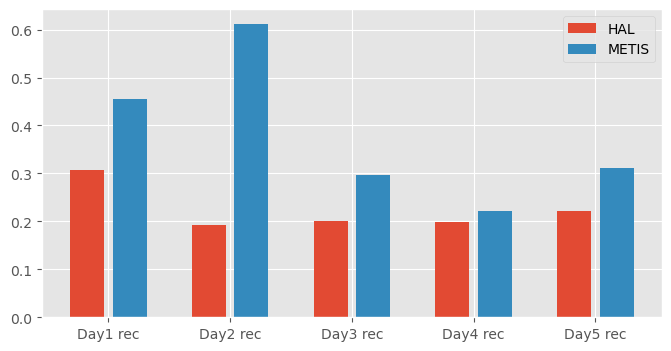

In [353]:
METIS_std = [M1_std_mean, M2_std_mean, M3_std_mean, M4_std_mean, M5_std_mean]
HAL_std = [H1_std_mean, H2_std_mean, H3_std_mean, H4_std_mean, H5_std_mean]

xx = ['Day1 rec', 'Day2 rec', 'Day3 rec', 'Day4 rec', 'Day5 rec']
x = np.array([i for i in range(5)])
bar_width = 0.35 
plt.figure(figsize = (8,4))
plt.bar(x - bar_width/2, HAL_std, bar_width*0.8, label = 'HAL')
plt.bar(x + bar_width/2, METIS_std, bar_width*0.8, label = 'METIS')
plt.xticks(x, xx)
plt.legend()
plt.savefig('plot/Experiment_variation.png', bbox_inches='tight', dpi = 300)

In [280]:
METIS_std, HAL_std

([0.45514327, 0.6117208, 0.29735467, 0.22167456, 0.3110621],
 [0.3066278, 0.19275984, 0.20057416, 0.19919714, 0.22152781])

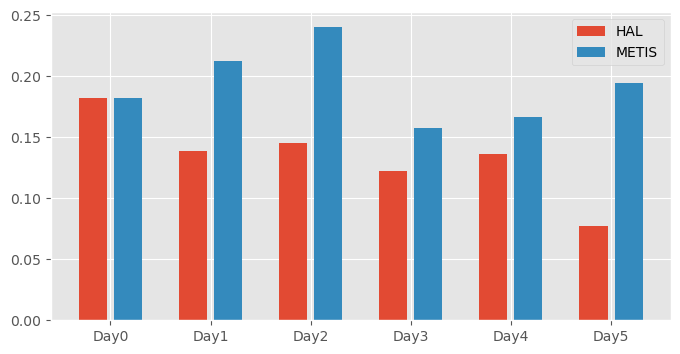

In [368]:
METIS_std_test = [std_test, M1_std_test, M2_std_test, M3_std_test, M4_std_test, M5_std_test]
HAL_std_test = [std_test, H1_std_test, H2_std_test, H3_std_test, H4_std_test, H5_std_test]

xx = ['Day0','Day1', 'Day2', 'Day3', 'Day4', 'Day5']
x = np.array([i for i in range(6)])
bar_width = 0.35 
plt.figure(figsize = (8,4))
plt.bar(x - bar_width/2, HAL_std_test, bar_width*0.8, label = 'HAL')
plt.bar(x + bar_width/2, METIS_std_test, bar_width*0.8, label = 'METIS')
plt.xticks(x, xx)
plt.legend()
plt.savefig('plot/Experiment_variation_test.png', bbox_inches='tight', dpi = 300)

#### METIS optim

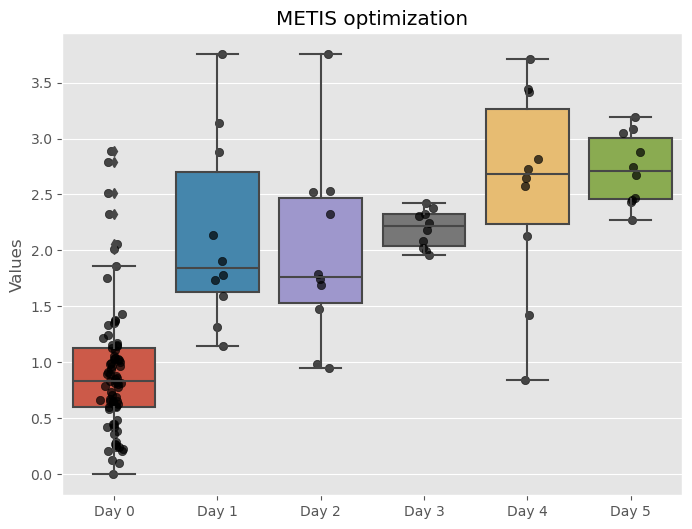

In [176]:
data = {
    'Day 0': y_train,
    'Day 1': METIS_day1_optim_label_processed,
    'Day 2': METIS_day2_optim_label_processed,
    'Day 3': METIS_day3_optim_label_processed,
    'Day 4': METIS_day4_optim_label_processed,
    'Day 5': METIS_day5_optim_label_processed
}

labels = list(data.keys())
values = list(data.values())

# 플롯을 그릴 Figure와 Axes 생성
fig, ax = plt.subplots(figsize=(8, 6))

# 박스 플롯 그리기
sns.boxplot(data=values, ax=ax)
ax.set_xticklabels(labels)

# 박스 플롯 위에 산점도 그리기
for i, v in enumerate(values):
    x = np.random.normal(i, 0.04, size=len(v))  # x 좌표에 약간의 노이즈 추가
    ax.scatter(x, v, alpha=0.7, color='black')

ax.set_title("METIS optimization")
ax.set_ylabel("Values")
plt.savefig('plot/METIS optimization.png')
# 플롯 출력
plt.show()

In [177]:
np.max(y_train),np.max(METIS_day1_optim_label_processed),np.max(METIS_day2_optim_label_processed),np.max(METIS_day3_optim_label_processed),np.max(METIS_day4_optim_label_processed), np.max(METIS_day5_optim_label_processed)

(2.8927038626666666,
 3.752941176666667,
 3.752941176666667,
 2.424908425,
 3.7133333336666667,
 3.1941031943333336)

#### Analysis

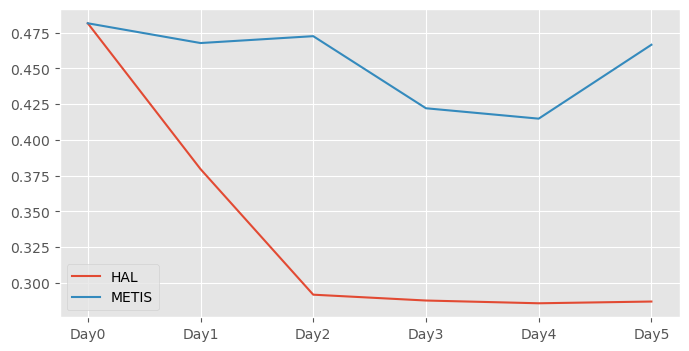

In [334]:
HAL_test_mae = [0.4814863115,0.3795514369,0.2917309701,0.2876457206,0.2857185438,0.2869365272]
METIS_test_mae = [0.4814863115, 0.4676705544, 0.4724748308 ,0.4220651402,0.4148042775,0.4664703082]
xx = ['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5']
x = [i for i in range(6)]
plt.figure(figsize = (8,4))
plt.plot(x, HAL_test_mae, label = 'HAL')
plt.plot(x, METIS_test_mae, label = 'METIS')
plt.xticks(x, xx)
plt.legend()
plt.savefig('plot/Experiment_mae.png', bbox_inches='tight', dpi = 300)

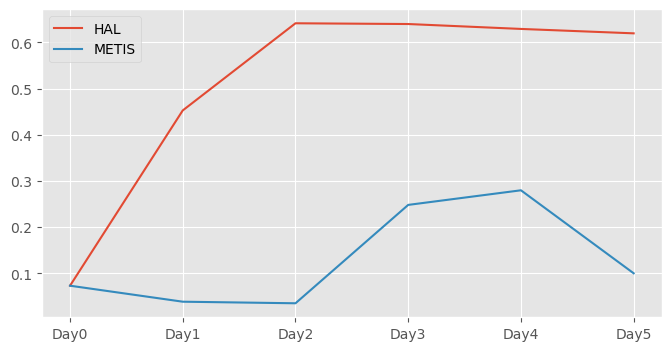

In [335]:
HAL_test_r2 = [0.0733618144,0.4529212284,0.641620769,0.6400036544,0.6293823531,0.6198351807]
METIS_test_r2 = [0.0733618144,0.03871636257,0.0353053921,0.2483366905,0.2799626381,0.1002466998]
xx = ['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5']
x = [i for i in range(6)]
plt.figure(figsize = (8,4))
plt.plot(x, HAL_test_r2, label = 'HAL')
plt.plot(x, METIS_test_r2, label = 'METIS')
plt.xticks(x, xx)
plt.legend()
plt.savefig('plot/Experiment_r2.png', bbox_inches='tight', dpi = 300)

In [211]:
importance_total = []
shap_values_total = []
for p in HAL_day5_params_list:
    model_for_importance = XGBRegressor(**p)
    model_for_importance.fit(scaled_HAL_day5_X_train, HAL_day5_y_train)
    pred_tmp = model_for_importance.predict(scaled_X_test)
    r2_tmp = r2_score(random_label_processed, pred_tmp)
    if r2_tmp >= 0.6:
        print(r2_tmp)   
        explainer = shap.Explainer(model_for_importance)
        shap_values = explainer(pd.DataFrame(scaled_HAL_day5_X_train, columns = lycopene_processed_onehot.columns.tolist()))
        shap_values_total.append(shap_values.values)
        importance = model_for_importance.feature_importances_
        importance_total.append(importance)


0.6638834933930129
0.6355882432141731
0.6230979224405249
0.6367971024057503
0.6768122762551085
0.6027353429849005


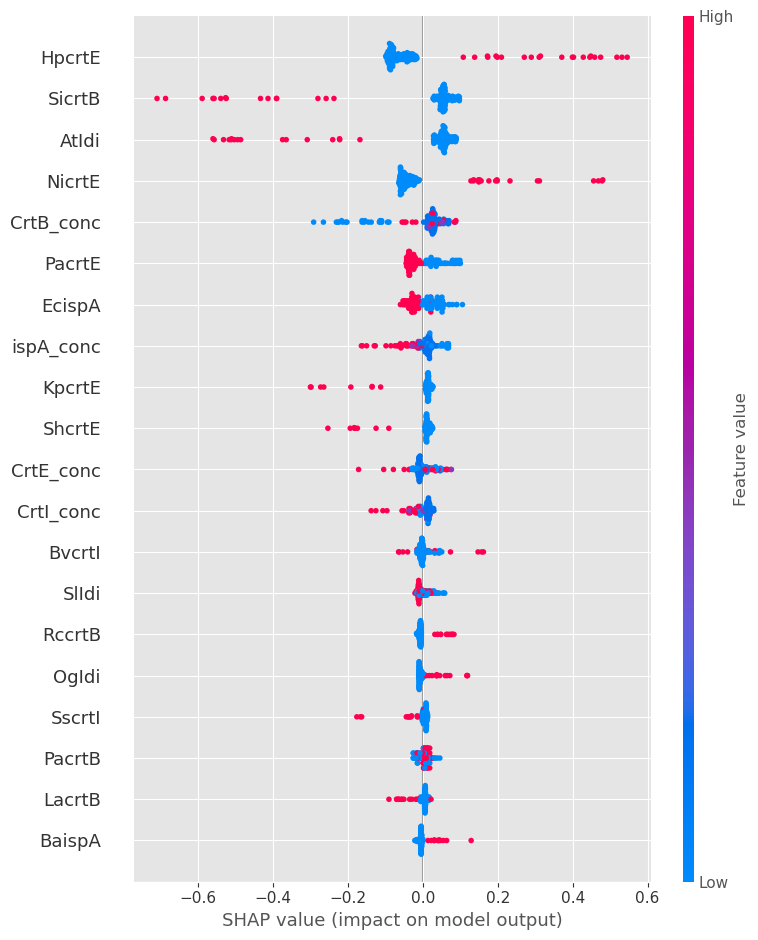

In [212]:
mean_shap_values = np.mean(shap_values_total, axis=0)
plt.figure(figsize = (8,6))
shap.summary_plot(mean_shap_values, scaled_HAL_day5_X_train, feature_names = lycopene_processed_onehot.columns.tolist())
#plt.savefig("plot/Experiment_shap_summary.png", bbox_inches='tight')
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SicrtB vs. not SicrtB: t-test independent samples, P_val:1.269e-04 t=-3.956e+00
AtIdi vs. not AtIdi: t-test independent samples, P_val:5.559e-04 t=-3.544e+00
KpcrtE vs. not KpcrtE: t-test independent samples, P_val:4.417e-02 t=-2.033e+00
HpcrtE vs. not HpcrtE: t-test independent samples, P_val:9.106e-05 t=4.045e+00


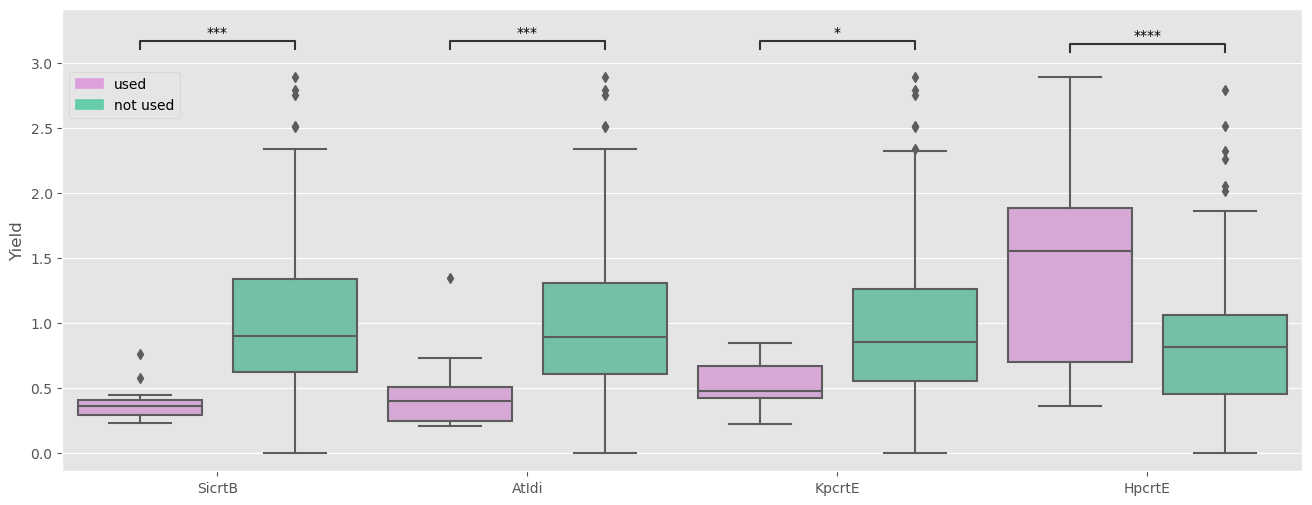

In [507]:
import matplotlib.patches as mpatches

sicrtb_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['SicrtB'] == 1].index.tolist()]
sicrtb_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['SicrtB'] != 1].index.tolist()]
atldi_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['AtIdi'] == 1].index.tolist()]
atldi_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['AtIdi'] != 1].index.tolist()]
kpcrte_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['KpcrtE'] == 1].index.tolist()]
kpcrte_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['KpcrtE'] != 1].index.tolist()]
hpcrte_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['HpcrtE'] == 1].index.tolist()]
hpcrte_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['HpcrtE'] != 1].index.tolist()]


data = pd.DataFrame({
    'Group': ['SicrtB']*len(sicrtb_pos) + ['not SicrtB']*len(sicrtb_neg) + ['AtIdi']*len(atldi_pos) + ['not AtIdi']*len(atldi_neg) + 
    ['KpcrtE']*len(kpcrte_pos) + ['not KpcrtE']*len(kpcrte_neg) + ['HpcrtE']*len(hpcrte_pos) + ['not HpcrtE']*len(hpcrte_neg),
    'Yield': np.concatenate([sicrtb_pos, sicrtb_neg, atldi_pos, atldi_neg, kpcrte_pos, kpcrte_neg , hpcrte_pos, hpcrte_neg]),
    'Pair' : ['SicrtB']*len(HAL_day5_y_train) + ['AtIdi']*len(HAL_day5_y_train) + ['KpcrtE']*len(HAL_day5_y_train) + ['HpcrtE']*len(HAL_day5_y_train)
})

plt.figure(figsize = (16,6))
# 박스 플롯 생성
my_pal = {"SicrtB": "#DDA0DD", "not SicrtB": "#66CDAA", "AtIdi": "#DDA0DD", "not AtIdi": "#66CDAA",
         "KpcrtE": "#DDA0DD", "not KpcrtE": "#66CDAA", "HpcrtE": "#DDA0DD", "not HpcrtE": "#66CDAA"}
ax = sns.boxplot(x="Group", y="Yield", data=data, palette = my_pal)
ax.set_xlabel('')
legend_handles = [
    mpatches.Patch(color='#DDA0DD', label='used'),mpatches.Patch(color='#66CDAA', label='not used')]
# 범례 위치 및 추가
plt.legend(handles=legend_handles, bbox_to_anchor=(0, 0.88), loc='upper left')
plt.xticks(ticks=[0.5, 2.5, 4.5, 6.5], labels=['SicrtB', 'AtIdi',"KpcrtE", "HpcrtE" ])

pairs = [("SicrtB", "not SicrtB"), ("AtIdi", "not AtIdi"), ("KpcrtE", "not KpcrtE"), ("HpcrtE", "not HpcrtE")]
annotator = Annotator(ax, pairs, data=data, x="Group", y="Yield")
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('plot/Experiment_important_enzyme.png', bbox_inches='tight', dpi = 300)
plt.show()

In [214]:
shap.initjs() 
shap.plots.force(shap_values)

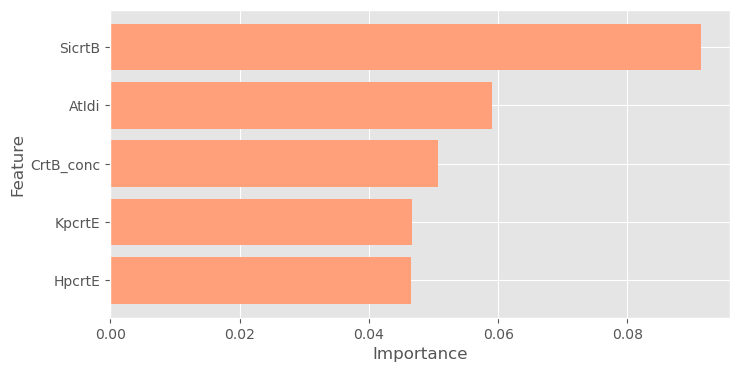

In [470]:
importance_mean = np.mean(importance_total, axis = 0)
importance_df = pd.DataFrame({'Feature': lycopene_processed_onehot.columns.tolist(), 'Importance': importance_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'][:5][::-1], importance_df['Importance'][:5][::-1], color = '#FFA07A')
plt.xlabel('Importance')
plt.ylabel('Feature')
#plt.title('Feature Importance')
plt.savefig('plot/Experiment_importance.png', bbox_inches='tight', dpi = 300)

In [481]:
importance_df.tail()

,Feature,Importance
9,PacrtE,0.026017
5,KaispA,0.023625
19,PacrtI,0.023143
6,JcispA,0.022590
2,RcIdi,0.017271


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RcIdi vs. not RcIdi: t-test independent samples, P_val:5.355e-01 t=6.214e-01
JcispA vs. not JcispA: t-test independent samples, P_val:8.269e-01 t=2.192e-01
PacrtI vs. not PacrtI: t-test independent samples, P_val:7.037e-01 t=-3.811e-01
KaispA vs. not KaispA: t-test independent samples, P_val:7.232e-01 t=3.550e-01


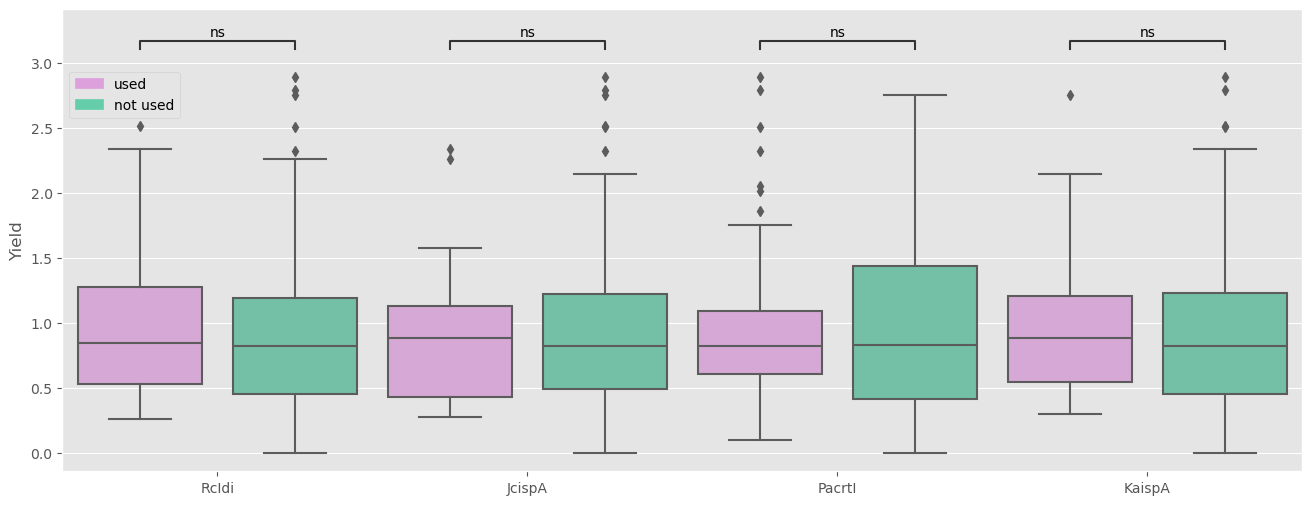

In [506]:
rcidi_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['RcIdi'] == 1].index.tolist()]
rcidi_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['RcIdi'] != 1].index.tolist()]
jcispa_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['JcispA'] == 1].index.tolist()]
jcispa_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['JcispA'] != 1].index.tolist()]
pacrtl_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['PacrtI'] == 1].index.tolist()]
pacrtl_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['PacrtI'] != 1].index.tolist()]
kaispa_pos = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['KaispA'] == 1].index.tolist()]
kaispa_neg = HAL_day5_y_train[HAL_day5_X_train.loc[HAL_day5_X_train['KaispA'] != 1].index.tolist()]


data = pd.DataFrame({
    'Group': ['RcIdi']*len(rcidi_pos) + ['not RcIdi']*len(rcidi_neg) + ['JcispA']*len(jcispa_pos) + ['not JcispA']*len(jcispa_neg) + 
    ['PacrtI']*len(pacrtl_pos) + ['not PacrtI']*len(pacrtl_neg) + ['KaispA']*len(kaispa_pos) + ['not KaispA']*len(kaispa_neg),
    'Yield': np.concatenate([rcidi_pos, rcidi_neg, jcispa_pos, jcispa_neg, pacrtl_pos, pacrtl_neg , kaispa_pos, kaispa_neg]),
    'Pair' : ['RcIdi']*len(HAL_day5_y_train) + ['JcispA']*len(HAL_day5_y_train) + ['PacrtI']*len(HAL_day5_y_train) + ['KaispA']*len(HAL_day5_y_train)
})

plt.figure(figsize = (16,6))
# 박스 플롯 생성
my_pal = {"RcIdi": "#DDA0DD", "not RcIdi": "#66CDAA", "JcispA": "#DDA0DD", "not JcispA": "#66CDAA",
         "PacrtI": "#DDA0DD", "not PacrtI": "#66CDAA", "KaispA": "#DDA0DD", "not KaispA": "#66CDAA"}
ax = sns.boxplot(x="Group", y="Yield", data=data, palette = my_pal)
ax.set_xlabel('')
legend_handles = [
    mpatches.Patch(color='#DDA0DD', label='used'),mpatches.Patch(color='#66CDAA', label='not used')]
# 범례 위치 및 추가
plt.legend(handles=legend_handles, bbox_to_anchor=(0, 0.88), loc='upper left')
plt.xticks(ticks=[0.5, 2.5, 4.5, 6.5], labels=['RcIdi', 'JcispA',"PacrtI", "KaispA" ])

pairs = [("RcIdi", "not RcIdi"), ("JcispA", "not JcispA"), ("PacrtI", "not PacrtI"), ("KaispA", "not KaispA")]
annotator = Annotator(ax, pairs, data=data, x="Group", y="Yield")
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

#plt.savefig('plot/Experiment_not_important_enzyme.png', bbox_inches='tight', dpi = 300)
plt.show()

In [23]:
np.random.seed(42)
#sample_idx = np.random.choice([i for i in range(2688000)],size = int(2688000*0.3))
ALL_conditions_sampled = scaled_ALL_possible_conditions

In [24]:
ALL_conditions_sampled_df = pd.DataFrame(ALL_conditions_sampled)
ALL_conditions_sampled_df['label'] = ['Total']*len(ALL_conditions_sampled_df)

METIS_recommend_df = pd.DataFrame(scaled_METIS_day5_X_train[-50:, :])
METIS_recommend_df['label'] = ['METIS']*len(METIS_recommend_df)

HAL_recommend_df = pd.DataFrame(scaled_HAL_day5_X_train[-50:, :])
HAL_recommend_df['label'] = ['HAL']*len(HAL_recommend_df)

In [25]:
total_df = pd.concat([ALL_conditions_sampled_df, METIS_recommend_df, HAL_recommend_df]).reset_index(drop = True)
METIS_idx = total_df.loc[total_df['label'] == 'METIS'].index.tolist()
HAL_idx = total_df.loc[total_df['label'] == 'HAL'].index.tolist()

In [26]:
total_df.shape

(2688100, 30)

In [27]:
from sklearn.manifold import TSNE

ALL_conditions_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(total_df.iloc[:, :29])

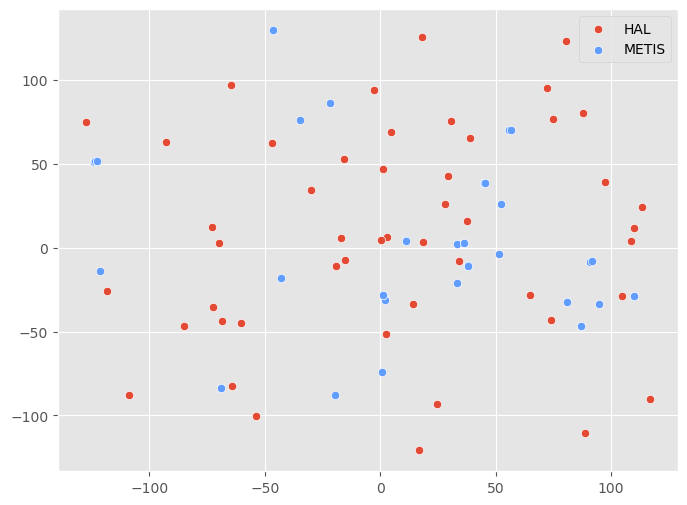

In [339]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx][:,0], y = ALL_conditions_tsne[HAL_idx][:, 1], label = 'HAL')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx][:, 0], y = ALL_conditions_tsne[METIS_idx][:, 1], label = 'METIS', color = '#619CFF') 

#plt.title('TSNE of recommended data')
plt.savefig('plot/Experiment_tsne.png', bbox_inches='tight', dpi = 300)
plt.show()

In [86]:
scaled_HAL_day5_X_train[-50:]

(50, 29)

In [68]:
num_points = 50
distances_HAL = []
distances_METIS = []

average_distance_HAL = []
average_distance_METIS = []
for i in range(num_points):
    for j in range(i + 1, num_points):  # 중복 계산 방지
        distance = np.linalg.norm(ALL_conditions_tsne[HAL_idx][i][:] - ALL_conditions_tsne[HAL_idx][j][:])  # 유클리드 거리
        distance2 = np.linalg.norm(ALL_conditions_tsne[METIS_idx][i][:] - ALL_conditions_tsne[METIS_idx][j][:]) 
        distances_HAL.append(distance)
        distances_METIS.append(distance2)
    if i%10 == 9:
        average_distance_HAL.append(np.mean(distances_HAL))
        average_distance_METIS.append(np.mean(distances_METIS))
# 거리 평균 계산

print("모든 점들 간 거리의 평균:", average_distance_HAL[-1])
print("모든 점들 간 거리의 평균:", average_distance_METIS[-1])

모든 점들 간 거리의 평균: 116.791374
모든 점들 간 거리의 평균: 107.52753


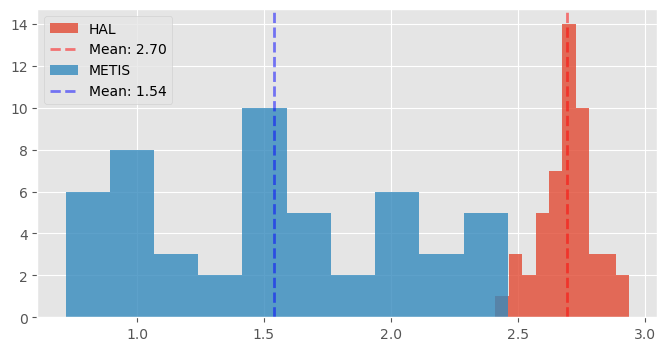

In [503]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(8, 4))
nbrs = NearestNeighbors(n_neighbors=10).fit(scaled_HAL_day5_X_train[-50:])
distances, _ = nbrs.kneighbors(scaled_HAL_day5_X_train[-50:])
mean_distances = np.mean(distances[:, 1:], axis=1)

nbrs2 = NearestNeighbors(n_neighbors=10).fit(scaled_METIS_day5_X_train[-50:])
distances2, _ = nbrs2.kneighbors(scaled_METIS_day5_X_train[-50:])
mean_distances2 = np.mean(distances2[:, 1:], axis=1)

plt.hist(mean_distances, bins=10, label = 'HAL', alpha = 0.8)
plt.axvline(np.mean(mean_distances), color='red', linestyle='--', linewidth=2, label=f"Mean: {np.mean(mean_distances):.2f}", alpha = 0.5)
plt.hist(mean_distances2, bins=10, label = 'METIS', alpha = 0.8)
plt.axvline(np.mean(mean_distances2), color='blue', linestyle='--', linewidth=2, label=f"Mean: {np.mean(mean_distances2):.2f}", alpha = 0.5)
plt.legend()

plt.savefig('plot/Experiment_knn_distance.png', bbox_inches='tight', dpi = 300)
plt.show()

In [97]:
np.mean(mean_distances), np.mean(mean_distances2)

(2.6951442475726606, 1.541368192149128)

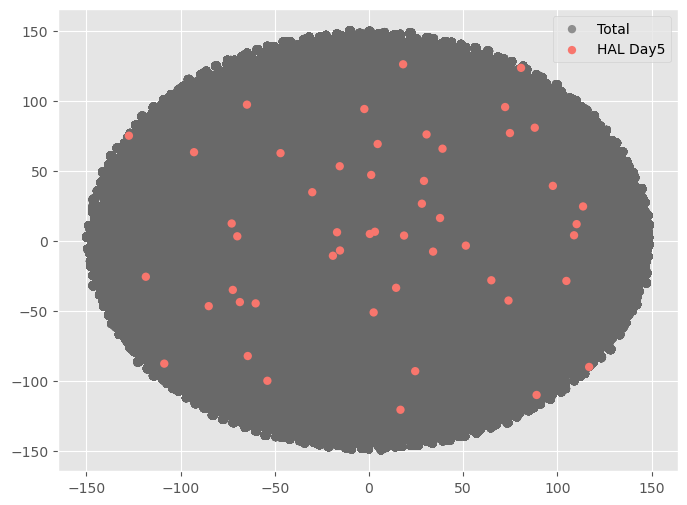

In [501]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total', alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx][:,0], y = ALL_conditions_tsne[HAL_idx][:, 1], label = 'HAL Day5', color = '#F8766D', edgecolor='none')

#plt.title('TSNE of HAL recommended data')
#plt.savefig('plot/Experiment_tsne_HAL_5.png', bbox_inches='tight', dpi = 300)
plt.show()

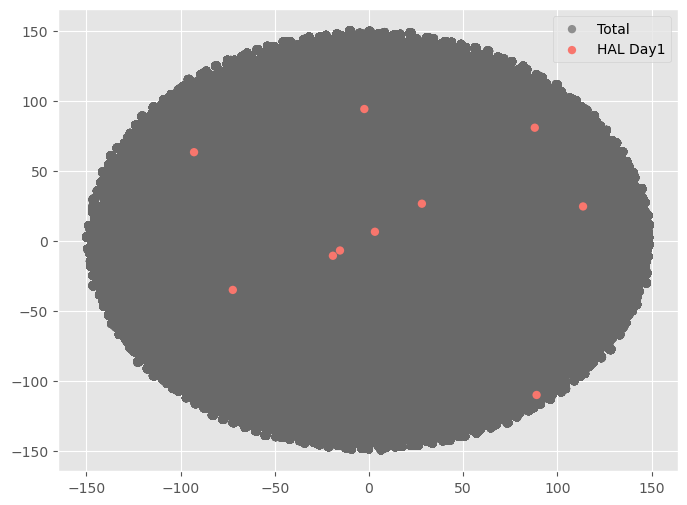

In [477]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total', alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx[:10]][:,0], y = ALL_conditions_tsne[HAL_idx[:10]][:, 1], label = 'HAL Day1', color = '#F8766D', edgecolor='none')

#plt.title('TSNE of HAL Day1 recommended data')
plt.savefig('plot/Experiment_tsne_HAL_1.png', bbox_inches='tight', dpi = 300)
plt.show()

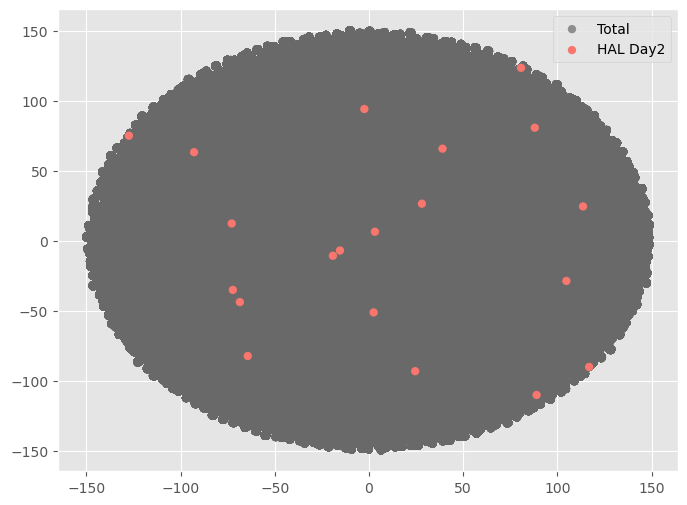

In [478]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total', alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx[:20]][:,0], y = ALL_conditions_tsne[HAL_idx[:20]][:, 1], label = 'HAL Day2', color = '#F8766D', edgecolor='none')

#plt.title('TSNE of HAL Day2 recommended data')
#plt.savefig('plot/Lycopene_tsne_HAL.png')
plt.savefig('plot/Experiment_tsne_HAL_2.png', bbox_inches='tight', dpi = 300)
plt.show()

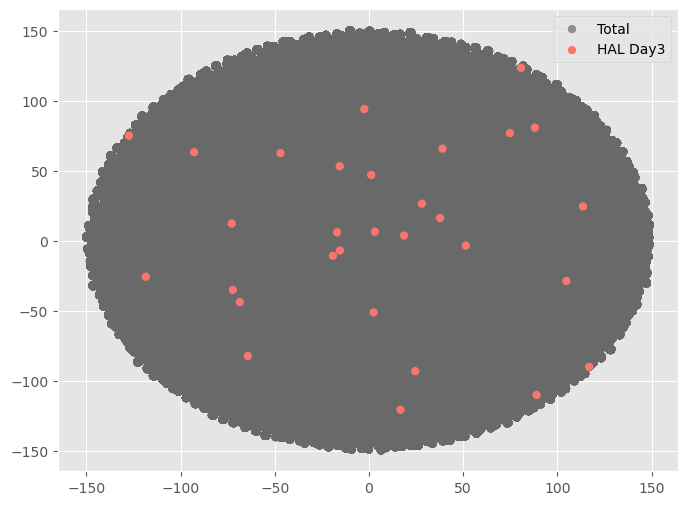

In [479]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total', alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx[:30]][:,0], y = ALL_conditions_tsne[HAL_idx[:30]][:, 1], label = 'HAL Day3', color = '#F8766D', edgecolor='none')

#plt.title('TSNE of HAL Day3 recommended data')
#plt.savefig('plot/Lycopene_tsne_HAL.png')
plt.savefig('plot/Experiment_tsne_HAL_3.png', bbox_inches='tight', dpi = 300)
plt.show()

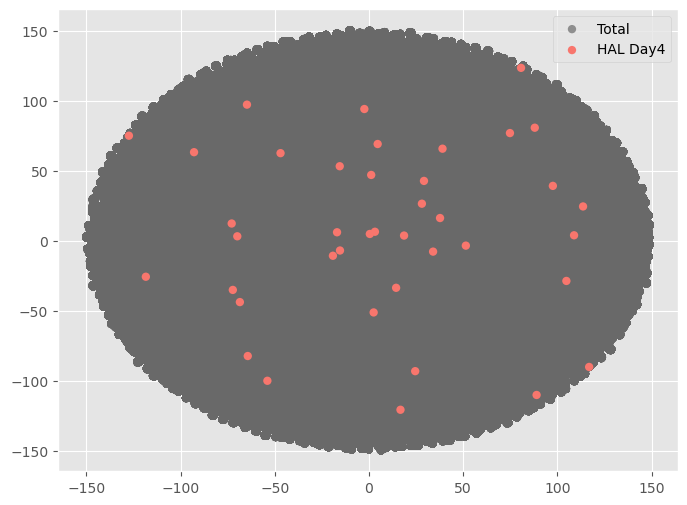

In [480]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total', alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[HAL_idx[:40]][:,0], y = ALL_conditions_tsne[HAL_idx[:40]][:, 1], label = 'HAL Day4', color = '#F8766D', edgecolor='none')

#plt.title('TSNE of HAL Day4 recommended data')
#plt.savefig('plot/Lycopene_tsne_HAL.png')
plt.savefig('plot/Experiment_tsne_HAL_4.png', bbox_inches='tight', dpi = 300)
plt.show()

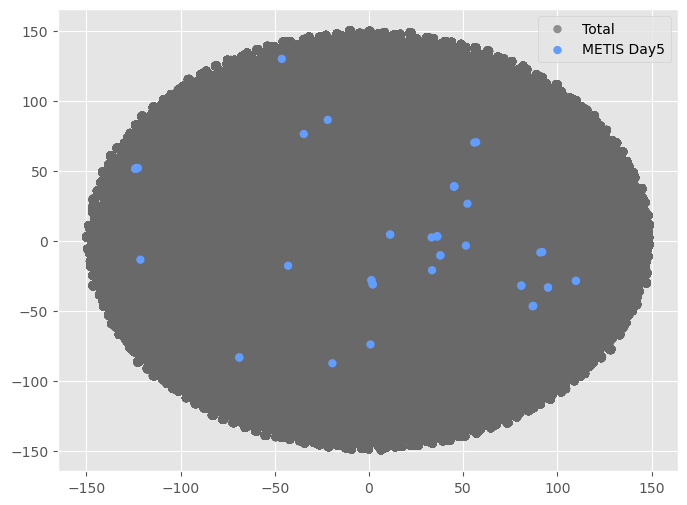

In [472]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total',alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx][:, 0], y = ALL_conditions_tsne[METIS_idx][:, 1], label = 'METIS Day5', color = '#619CFF', edgecolor='none')

#plt.title('TSNE of METIS recommended data')
plt.savefig('plot/Experiment_tsne_METIS_5.png', bbox_inches='tight', dpi = 300)
plt.show()

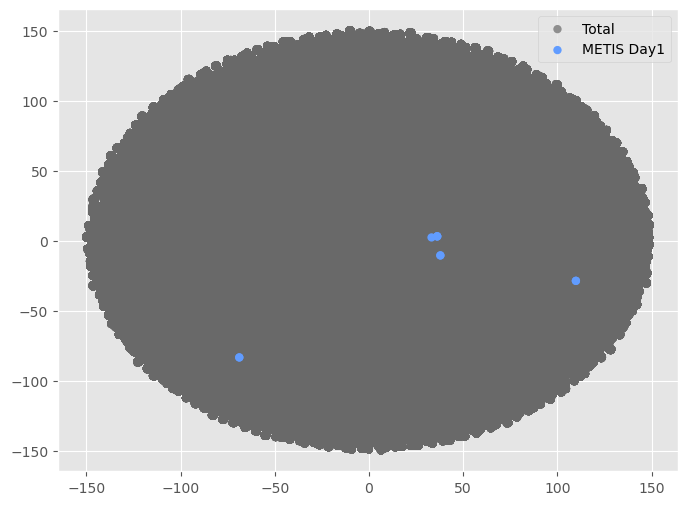

In [473]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total',alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx[:10]][:, 0], y = ALL_conditions_tsne[METIS_idx[:10]][:, 1], label = 'METIS Day1', color = '#619CFF', edgecolor='none')

#plt.title('TSNE of METIS Day1 recommended data')
#plt.savefig('plot/Lycopene_tsne_METIS.png')
plt.savefig('plot/Experiment_tsne_METIS_1.png', bbox_inches='tight', dpi = 300)
plt.show()

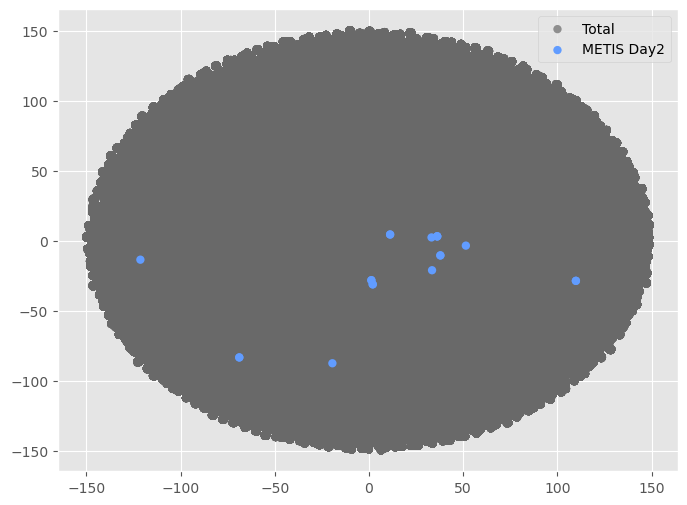

In [474]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total',alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx[:20]][:, 0], y = ALL_conditions_tsne[METIS_idx[:20]][:, 1], label = 'METIS Day2', color = '#619CFF', edgecolor='none')

#plt.title('TSNE of METIS Day2 recommended data')
#plt.savefig('plot/Lycopene_tsne_METIS.png')
plt.savefig('plot/Experiment_tsne_METIS_2.png', bbox_inches='tight', dpi = 300)
plt.show()

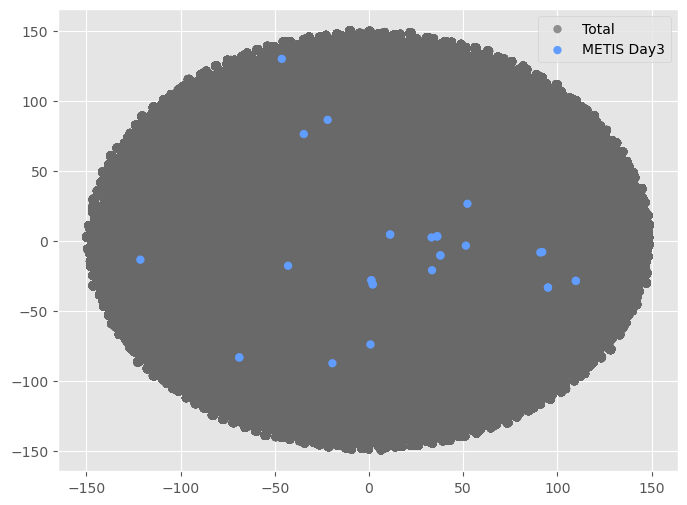

In [475]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total',alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx[:30]][:, 0], y = ALL_conditions_tsne[METIS_idx[:30]][:, 1], label = 'METIS Day3', color = '#619CFF', edgecolor='none')

#plt.title('TSNE of METIS Day3 recommended data')
#plt.savefig('plot/Lycopene_tsne_METIS.png')
plt.savefig('plot/Experiment_tsne_METIS_3.png', bbox_inches='tight', dpi = 300)
plt.show()

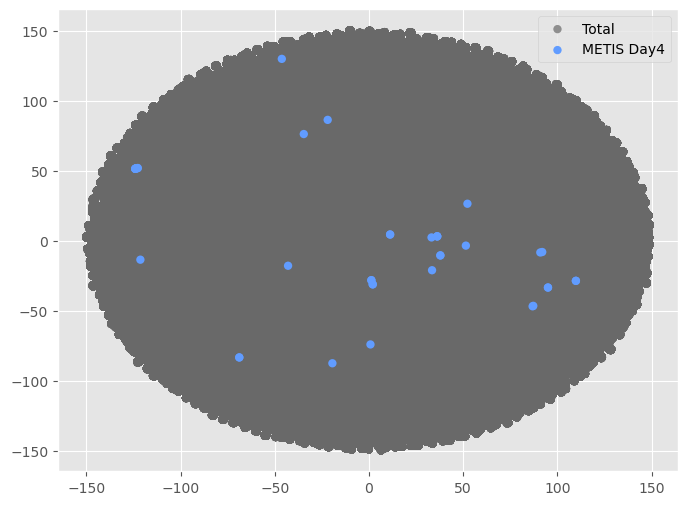

In [476]:
plt.figure(figsize = (8,6))

sns.scatterplot(x = ALL_conditions_tsne[:,0], y = ALL_conditions_tsne[:,1], label = 'Total',alpha = 0.7, color = '#696969', edgecolor='none')
sns.scatterplot(x = ALL_conditions_tsne[METIS_idx[:40]][:, 0], y = ALL_conditions_tsne[METIS_idx[:40]][:, 1], label = 'METIS Day4', color = '#619CFF', edgecolor='none')

#plt.title('TSNE of METIS Day4 recommended data')
#plt.savefig('plot/Lycopene_tsne_METIS.png')
plt.savefig('plot/Experiment_tsne_METIS_4.png', bbox_inches='tight', dpi = 300)
plt.show()